In [1]:
#Let us UPLOAD the desired libraries
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math
import math
from matplotlib.animation import FuncAnimation
np.set_printoptions(precision=15, suppress=False) #stablish the output number of decimals
import scipy.special as sp
import scipy.signal as signal
from scipy.optimize import root
!pip install numdifftools #necessary to compute numerical derivatives

## Computation of Neural System ODEs: E-I-I with an excitatory input

In [2]:
# The parameters we consider are as follows. For their biological significance, please refer to the thesis.
tau_e = 8
tau_i = 8
tau_2=8
tau_se = 1
tau_si = 5
tau_s2 = 30
Jee = 0
Jii = 0
J22 = 0
Jie = 13
Jei = 13
J2e = 13
Je2 = 13
Delta_e = 1
Delta_i = 1
Delta_2 = 1
eta_e = -5
eta_i = -5
eta_2 = -5
I_bar_e = 10
I_bar_i = 0
I_bar_2 = 0

# Initial condition: Taken from "Communication through coherence in a realistic neuronal model" by David Reyner Parra.
x0_david = [0.085262756825722,
1.125737037325799,
0.000000000000000,
0.209748707974244,
0.012828206758546,
-1.136491592341226,
0.834230210263032,
0.000000000000000]

x0_david_I = [0.085262756825722,
1.125737037325799,
0.000000000000000,
0.209748707974244,
0.012828206758546,
-1.136491592341226,
0.834230210263032,
0.000000000000000,
0.012828206758546,
-1.136491592341226,
0.209748707974244,
0.834230210263032,0]

# Neural network system of ODEs for the unperturbed system. 
#For details on their biological significance, please refer to the thesis.
def neural_network_notperturbed(x, t):

   # Compute the total external input to the neurons
    I_e = I_bar_e + tau_e * x[2] - tau_e * x[3]-tau_e*x[10]
    I_i = I_bar_i + tau_i * x[6] - tau_i * x[7]
    I_2 = I_bar_2 + tau_2 * x[11] - tau_2 * x[12]

    # System of equations (neuronal dynamics)
    dxdt = [
        (1 / tau_e) * (Delta_e / (np.pi * tau_e) + 2 * x[0] * x[1]),  # re
        (1 / tau_e) * (x[1] ** 2 + eta_e + I_e - (tau_e * np.pi * x[0]) ** 2),  # Ve
        (1 / tau_se) * (-x[2] + Jee * x[0]),  # See
        (1 / tau_si) * (-x[3] + Jei * x[4]),  # Sei
        (1 / tau_i) * (Delta_i / (np.pi * tau_i) + 2 * x[4] * x[5]),  # ri
        (1 / tau_i) * (x[5] ** 2 + eta_i + I_i - (tau_i * np.pi * x[4]) ** 2),  # Vi
        (1 / tau_se) * (-x[6] + Jie * x[0]),  # Sie
        (1 / tau_si) * (-x[7] + Jii * x[4]),   # Sii
        (1 / tau_2) * (Delta_2 / (np.pi * tau_2) + 2 * x[8] * x[9]),  # r2
        (1 / tau_2) * (x[9] ** 2 + eta_2 + I_2 - (tau_2 * np.pi * x[8]) ** 2),  # V2
        (1 / tau_s2) * (-x[10] + Je2 * x[8]),  # Se2
        (1 / tau_se) * (-x[11] + J2e * x[0]),  # S2e
        (1 / tau_s2) * (-x[12] + J22 * x[8])]  # S22
    return dxdt
    
    

In [3]:
# The following code implements the Poincaré section. 
#The theoretical background is explained in the appendix of the thesis.

# g(x) function which defines the Poincaré section
def g(x):
    return x[1]+0.5

def approximation_tau_dir(system, x0, g, atol, rtol, dir, plot, estimated_period):
    # Ensure t is strictly monotonic
    if dir == 1:
        t = np.linspace(0, estimated_period, 5000)
    elif dir == -1:
        t = np.linspace(0, -estimated_period, 5000)  # Reverse for monotonicity
    
    # Solve the ODE
    sol_simp = odeint(system, x0, t, atol=atol, rtol=rtol)
    x_i = sol_simp[1]
    
    # Find crossing of Poincaré section
    for i, xi in enumerate(sol_simp[1:], start=1):  # Avoid first element
        if g(x_i) * g(xi) <= 0:  # Check for sign change
            t0 = t[i]  # Time of crossing
            break
        x_i = xi  # Update x_i

    if plot == 1:
        # Plot the solution in the phase plane
        plt.figure(figsize=(4, 4))
        plt.plot(sol_simp[:, 0], sol_simp[:, 1])
        plt.xlabel('$r_e$ (kHz)')
        plt.ylabel('$V_e$ (mV)')
        plt.title('Periodic Oscillator')
        plt.grid(True)
        plt.show()

    return [xi, t0]

# One iteration of Newton's method
def DeltaT(x0):
    I_e = I_bar_e + tau_e * x0[2] - tau_e * x0[3]-tau_e*x0[10]
    Ve=(1/tau_e) * (x0[1]**2 + eta_e + I_e - (tau_e * np.pi * x0[0])**2)
    return - g(x0) / Ve

# Function to evaluate the system's solution at a given direction and time
def evaluate(system, x0, h, dir, atol, rtol):
    if dir == 1: t = np.linspace(0, h, 100)  # Small time step. Forward integration
    if dir == -1 : t = np.linspace(0, -h, 100) # Backward integration
    sol = odeint(system, x0, t, atol=atol, rtol=rtol)
    return sol[-1]

def poincare_map_n_periodic(system, x0,n, tol, atol, rtol,dir,plot,estimated_period):
    points = np.zeros((n, 13))  # To store intersection points
    X0=x0
    total_time = 0
    for i in range(n):
        # Use last intersection point as new initial condition
      if i != 0: x0 = xk
      approx = approximation_tau_dir(neural_network_notperturbed,x0,g,atol,rtol,dir,plot,estimated_period)
      xk = approx[0]
      total_time += approx[1]

      # Refine the intersection using Newton's method
      while abs(g(xk)) > tol:
            deltaT = DeltaT(xk)
            total_time += deltaT
            if deltaT < 0:
                  xk = evaluate(system, xk, abs(deltaT), -1, atol, rtol)
            else:
                  xk = evaluate(system, xk, abs(deltaT), 1, atol, rtol)
      points[i, :] = xk  # Store the refined intersection point

    return points,total_time, points[-1]


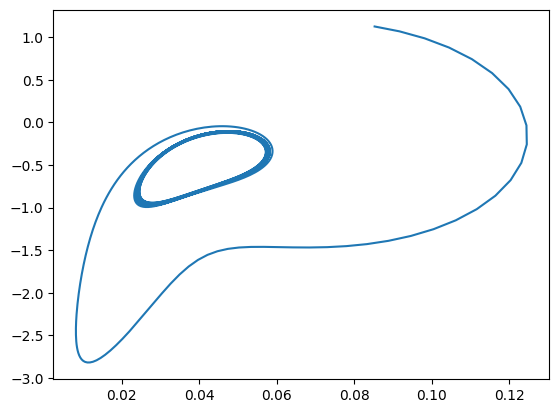

In [4]:
t = np.linspace(0, 550, 2500)

# Parameters
tol = 1e-16  # Tolerance for Newton's method
atol = 1e-17  # Absolute tolerance for ODE integration
rtol = 1e-13  # Relative tolerance for ODE integration

sol = odeint(neural_network_notperturbed, x0_david_I, t, atol=atol, rtol=rtol)
plt.plot(sol[:,0],sol[:,1])

32.59330373214927


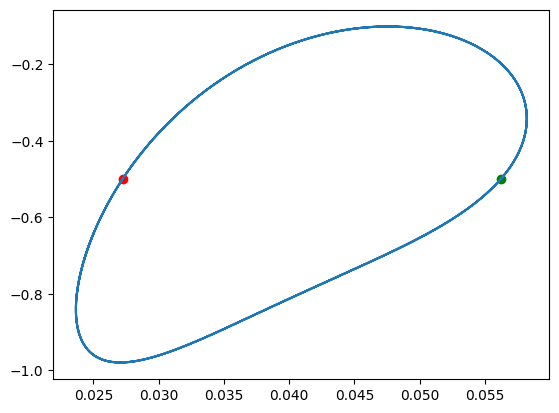

In [5]:
t = np.linspace(0, 1000, 25000)

# Parameters
tol = 1e-13  # Tolerance for Newton's method
atol = 1e-17  # Absolute tolerance for ODE integration
rtol = 1e-13  # Relative tolerance for ODE integration

sol = odeint(neural_network_notperturbed, x0_david_I, t, atol=atol, rtol=rtol)

# Time threshold to avoid the initial transient (e.g., 50 time units)
time_threshold = 800  # Time threshold in the simulation

# Only consider peaks that occur after the time threshold
valid_times = t[t >= time_threshold]
valid_r_e = sol[t >= time_threshold, 0]

# Find the peaks in the valid portion of r_e
peaks, _ = signal.find_peaks(valid_r_e)
# Compute the period by calculating the time difference between consecutive peaks
periods = np.diff(valid_times[peaks])  # Differences between consecutive peaks

# The estimated period
estimated_period = np.mean(periods)  # Average period
print(estimated_period)
x0=sol[-1]

t = np.linspace(0, 100, 2000)
sol = odeint(neural_network_notperturbed, x0, t, atol=atol, rtol=rtol)
plt.plot(sol[:,0],sol[:,1])

P_0= poincare_map_n_periodic(neural_network_notperturbed, x0,1, tol, atol, rtol, dir=1,plot=0,estimated_period=estimated_period)[2]
P_2= poincare_map_n_periodic(neural_network_notperturbed, P_0,1,1e-14, atol, rtol, dir=1,plot=0,estimated_period=estimated_period)[2]
plt.scatter(P_0[0],P_0[1],color='red')
plt.scatter(P_2[0],P_2[1],color='green')
plt.show()

In [6]:
# The following code is used to find a point that belongs to the oscillator and calculate its period T*.

def Poincare(x):
    result = poincare_map_n_periodic(
        neural_network_notperturbed,
        x,
        n=2,
        tol=tol,
        atol=atol,
        rtol=rtol,
        dir=1,
        plot=0,
        estimated_period=estimated_period
    )[2]-x
    return result

# Find the root of the Poincaré map
result = root(Poincare, P_0,method='hybr')

# Check and display the result of the root-finding process
if result.success:
    print(f"Root found: {result.x}")
else:
    print("No root found.")

P_1=result.x
Period = poincare_map_n_periodic(neural_network_notperturbed,P_1 ,2, tol, atol, rtol, dir=1,plot=0,estimated_period=estimated_period)[1]
print(f"Period of the oscillator, T* = {Period}")

Root found: [ 2.723336591092512e-02 -5.000000000000000e-01  8.874579125160360e-31
  2.360687747560961e-01  1.317638814312383e-02 -1.587163555867348e+00
  3.381568221708780e-01  7.893951564750365e-31  1.317638814312383e-02
 -1.587163555867348e+00  2.801844945174228e-01  3.381568221708780e-01
  0.000000000000000e+00]
Period of the oscillator, T* = 32.59044733754212


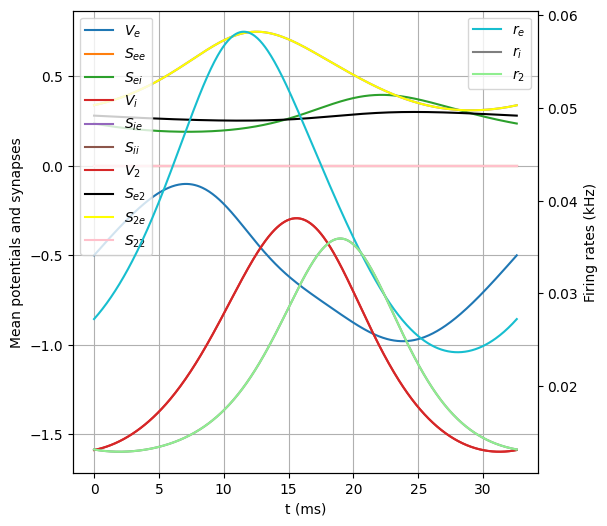

In [7]:
#Graphic representation of the oscillator
t = np.linspace(0, Period, 500)

# Parameters
tol = 1e-16  # Tolerance for Newton's method
atol = 1e-17  # Absolute tolerance for ODE integration
rtol = 1e-13  # Relative tolerance for ODE integration

sol = odeint(neural_network_notperturbed, P_1, t, atol=atol, rtol=rtol)

# Create a figure and primary axis
fig, ax1 = plt.subplots(figsize=(6, 6))

# Plot variables on the primary axis
ax1.plot(t, sol[:, 1], label=r'$V_e$', color='tab:blue')
ax1.plot(t, sol[:, 2], label=r'$S_{ee}$', color='tab:orange')
ax1.plot(t, sol[:, 3], label=r'$S_{ei}$', color='tab:green')
ax1.plot(t, sol[:, 5], label=r'$V_i$', color='tab:red')
ax1.plot(t, sol[:, 6], label=r'$S_{ie}$', color='tab:purple')
ax1.plot(t, sol[:, 7], label=r'$S_{ii}$', color='tab:brown')
ax1.plot(t, sol[:, 9], label=r'$V_2$', color='tab:red')
ax1.plot(t, sol[:, 10], label=r'$S_{e2}$', color='black')
ax1.plot(t, sol[:, 11], label=r'$S_{2e}$', color='yellow')
ax1.plot(t, sol[:, 12], label=r'$S_{22}$', color='pink')

ax1.set_xlabel('t (ms)')
ax1.set_ylabel('Mean potentials and synapses')
ax1.grid(True)
ax1.legend(loc='upper left')

# Create a secondary axis for firing rates
ax2 = ax1.twinx()
ax2.plot(t, sol[:, 0], label=r'$r_e$', color='tab:cyan')
ax2.plot(t, sol[:, 4], label=r'$r_i$', color='tab:gray')
ax2.plot(t, sol[:, 8], label=r'$r_2$', color='lightgreen')

ax2.set_ylabel('Firing rates (kHz)')
ax2.legend(loc='upper right')

#plt.title('Mean Potentials, Synapses, and Firing Rates')
plt.show()


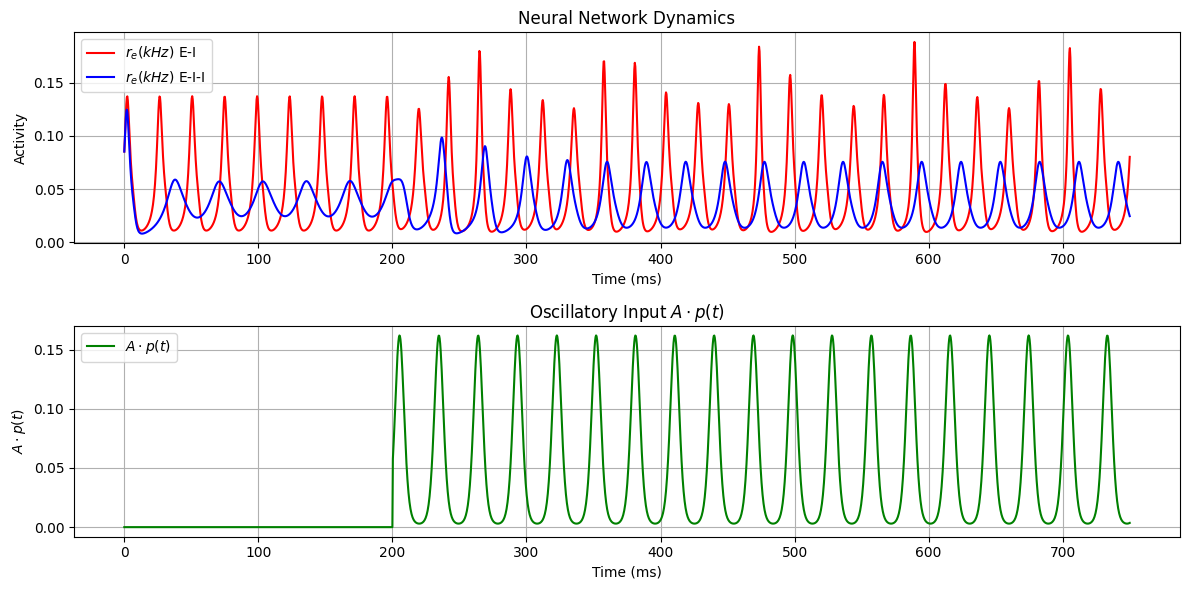

In [13]:
#Define the excitatory input with mu=0 and coherence kappa=2

A = 0.05  # You can change the value of A for the oscillatory input
T = 0.9*Period
mu = 0
k = 2

# External input function 
def p(t):
    I0_value = sp.iv(0, k)  # modified Bessel function of order 0
    return T * (np.exp(k * np.cos(((2 * np.pi) * (t - mu)) / T))) / (T * I0_value)

def p_plot(t):
    I0_value = sp.iv(0, k)  # modified Bessel function of order 0
    # Apply the condition element-wise to the array `t`
    return np.where(t < 200, 0, T * np.exp(k * np.cos((2 * np.pi * (t - mu)) / T)) / (T * I0_value))


# Neural network system of ODEs for the perturbed system. 
#For details on their biological significance, please refer to the thesis.
def neural_network_I_plot(x, t):
    # External inputs for excitatory and inhibitory neurons
    I_e_ext = I_bar_e + tau_e * A * p_plot(t)
    I_i_ext = I_bar_i + tau_i * A * p_plot(t)
    I_2_ext = I_bar_2

    # Compute the total external input to the neurons
    I_e = I_e_ext + tau_e * x[2] - tau_e * x[3]-tau_e*x[10]
    I_i = I_i_ext + tau_i * x[6] - tau_i * x[7]
    I_2 = I_2_ext + tau_2 * x[11] - tau_2 * x[12]

    # System of equations (neuronal dynamics)
    dxdt = [
        (1 / tau_e) * (Delta_e / (np.pi * tau_e) + 2 * x[0] * x[1]),  # re
        (1 / tau_e) * (x[1] ** 2 + eta_e + I_e - (tau_e * np.pi * x[0]) ** 2),  # Ve
        (1 / tau_se) * (-x[2] + Jee * x[0]),  # See
        (1 / tau_si) * (-x[3] + Jei * x[4]),  # Sei
        (1 / tau_i) * (Delta_i / (np.pi * tau_i) + 2 * x[4] * x[5]),  # ri
        (1 / tau_i) * (x[5] ** 2 + eta_i + I_i - (tau_i * np.pi * x[4]) ** 2),  # Vi
        (1 / tau_se) * (-x[6] + Jie * x[0]),  # Sie
        (1 / tau_si) * (-x[7] + Jii * x[4]),   # Sii
        (1 / tau_2) * (Delta_2 / (np.pi * tau_2) + 2 * x[8] * x[9]),  # r2
        (1 / tau_2) * (x[9] ** 2 + eta_2 + I_2 - (tau_2 * np.pi * x[8]) ** 2),  # V2
        (1 / tau_s2) * (-x[10] + Je2 * x[8]),  # Se2
        (1 / tau_se) * (-x[11] + J2e * x[0]),  # S2e
        (1 / tau_s2) * (-x[12] + J22 * x[8])  # S22
    ]
    return dxdt

# Neural network system of ODEs
def neural_network_plot(x, t):
    # External inputs for excitatory and inhibitory neurons
    I_e_ext = I_bar_e + tau_e * A * p_plot(t)
    I_i_ext = I_bar_i + tau_i * A * p_plot(t)

    # Compute the total external input to the neurons
    I_e = I_e_ext + tau_e * x[2] - tau_e * x[3]
    I_i = I_i_ext + tau_i * x[6] - tau_i * x[7]

    # System of equations (neuronal dynamics)
    dxdt = [
        (1 / tau_e) * (Delta_e / (np.pi * tau_e) + 2 * x[0] * x[1]),  # re
        (1 / tau_e) * (x[1] ** 2 + eta_e + I_e - (tau_e * np.pi * x[0]) ** 2),  # Ve
        (1 / tau_se) * (-x[2] + Jee * x[0]),  # See
        (1 / tau_si) * (-x[3] + Jei * x[4]),  # Sei
        (1 / tau_i) * (Delta_i / (np.pi * tau_i) + 2 * x[4] * x[5]),  # ri
        (1 / tau_i) * (x[5] ** 2 + eta_i + I_i - (tau_i * np.pi * x[4]) ** 2),  # Vi
        (1 / tau_se) * (-x[6] + Jie * x[0]),  # Sie
        (1 / tau_si) * (-x[7] + Jii * x[4])   # Sii
    ]
    return dxdt


# Time span for integration
t = np.linspace(0, 750, 2000)

# Solve the system of equations
atol = 1e-17
rtol = 1e-13
sol_plot = odeint(neural_network_plot, x0_david, t, atol=atol, rtol=rtol)
sol_plot_I = odeint(neural_network_I_plot, x0_david_I, t, atol=atol, rtol=rtol)

# Compute the oscillatory term A*p(t)
oscillatory_term = A * p_plot(t)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot r_e and r_i (neural network dynamics)
plt.subplot(2, 1, 1)
plt.plot(t, sol_plot[:, 0], label='$r_e (kHz)$ E-I', color='r')
plt.plot(t, sol_plot_I[:, 0], label='$r_e (kHz)$ E-I-I', color='b')
plt.xlabel('Time (ms)')
plt.ylabel('Activity')
plt.legend()
plt.title('Neural Network Dynamics')
plt.grid(True)

# Plot A*p(t) (oscillatory term)
plt.subplot(2, 1, 2)
plt.plot(t, oscillatory_term, label=r'$A \cdot p(t)$', color='g')
plt.xlabel('Time (ms)')
plt.ylabel(r'$A \cdot p(t)$')
plt.legend()
plt.title('Oscillatory Input $A \cdot p(t)$')
plt.grid(True)

plt.tight_layout()
plt.show()



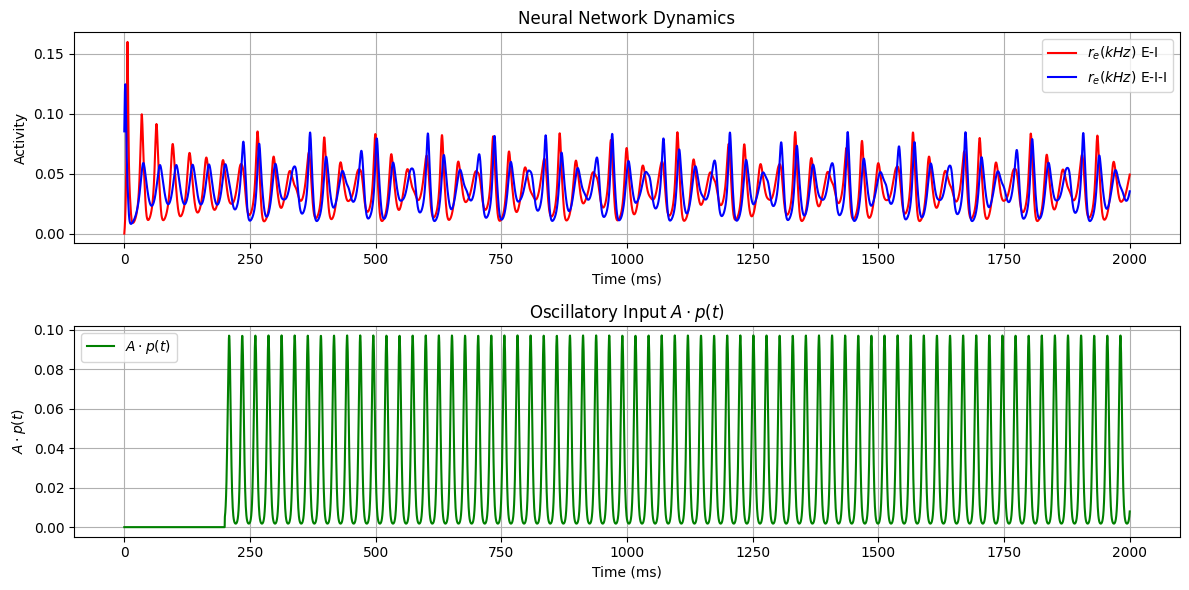

In [14]:
# Parameters

A = 0.03  # You can change the value of A for the oscillatory input
T = 0.8*Period
mu = 0
k = 2

# External input function (e.g., sinusoidal)
def p(t,T):
    I0_value = sp.iv(0, k)  # modified Bessel function of order 0
    return T * (np.exp(k * np.cos(((2 * np.pi) * (t - mu)) / T))) / (T * I0_value)

def p_plot(t):
    I0_value = sp.iv(0, k)  # modified Bessel function of order 0
    # Apply the condition element-wise to the array `t`
    return np.where(t < 200, 0, T * np.exp(k * np.cos((2 * np.pi * (t - mu)) / T)) / (T * I0_value))


# Neural network system of ODEs
def neural_network_I_plot(x, t):
    # External inputs for excitatory and inhibitory neurons
    I_e_ext = I_bar_e + tau_e * A * p_plot(t)
    I_i_ext = I_bar_i + tau_i * A * p_plot(t)
    I_2_ext = I_bar_2

    # Compute the total external input to the neurons
    I_e = I_e_ext + tau_e * x[2] - tau_e * x[3]-tau_e*x[10]
    I_i = I_i_ext + tau_i * x[6] - tau_i * x[7]
    I_2 = I_2_ext + tau_2 * x[11] - tau_2 * x[12]

    # System of equations (neuronal dynamics)
    dxdt = [
        (1 / tau_e) * (Delta_e / (np.pi * tau_e) + 2 * x[0] * x[1]),  # re
        (1 / tau_e) * (x[1] ** 2 + eta_e + I_e - (tau_e * np.pi * x[0]) ** 2),  # Ve
        (1 / tau_se) * (-x[2] + Jee * x[0]),  # See
        (1 / tau_si) * (-x[3] + Jei * x[4]),  # Sei
        (1 / tau_i) * (Delta_i / (np.pi * tau_i) + 2 * x[4] * x[5]),  # ri
        (1 / tau_i) * (x[5] ** 2 + eta_i + I_i - (tau_i * np.pi * x[4]) ** 2),  # Vi
        (1 / tau_se) * (-x[6] + Jie * x[0]),  # Sie
        (1 / tau_si) * (-x[7] + Jii * x[4]),   # Sii
        (1 / tau_2) * (Delta_2 / (np.pi * tau_2) + 2 * x[8] * x[9]),  # r2
        (1 / tau_2) * (x[9] ** 2 + eta_2 + I_2 - (tau_2 * np.pi * x[8]) ** 2),  # V2
        (1 / tau_s2) * (-x[10] + Je2 * x[8]),  # Se2
        (1 / tau_se) * (-x[11] + J2e * x[0]),  # S2e
        (1 / tau_s2) * (-x[12] + J22 * x[8])  # S22
    ]
    return dxdt




# Time span for integration
t = np.linspace(0, 2000, 5000)

# Solve the system of equations
atol = 1e-17
rtol = 1e-13
X0=[0,1,1,0,1,1,1,0,1,1,0,1,1]
sol_plot_2 = odeint(neural_network_I_plot, X0, t, atol=atol, rtol=rtol)
sol_plot_I = odeint(neural_network_I_plot, x0_david_I, t, atol=atol, rtol=rtol)

# Compute the oscillatory term A*p(t)
oscillatory_term = A * p_plot(t)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot r_e and r_i (neural network dynamics)
plt.subplot(2, 1, 1)
plt.plot(t, sol_plot_2[:, 0], label='$r_e (kHz)$ E-I', color='r')
plt.plot(t, sol_plot_I[:, 0], label='$r_e (kHz)$ E-I-I', color='b')
plt.xlabel('Time (ms)')
plt.ylabel('Activity')
plt.legend()
plt.title('Neural Network Dynamics')
plt.grid(True)

# Plot A*p(t) (oscillatory term)
plt.subplot(2, 1, 2)
plt.plot(t, oscillatory_term, label=r'$A \cdot p(t)$', color='g')
plt.xlabel('Time (ms)')
plt.ylabel(r'$A \cdot p(t)$')
plt.legend()
plt.title('Oscillatory Input $A \cdot p(t)$')
plt.grid(True)

plt.tight_layout()
plt.show()

### Phase equation


In [15]:
# The following code implements the definitions needed to compute the iPRC.

from scipy.interpolate import interp1d

# Jacobian of the system F(x)
def jacobian(x):
    # Jacobian matrix of the neural network system
    jacobian_matrix = np.zeros((13, 13))

    # For brevity, we'll fill in only the first few rows as an example (you should complete this based on your system).
    jacobian_matrix[0, 0] = (1 / tau_e) * (2 * x[1])  # df0/dx0
    jacobian_matrix[0, 1] = (1 / tau_e) * (2 * x[0])  # df0/dx1
    jacobian_matrix[1, 10] = -1  # df1/dx10
    jacobian_matrix[1, 0] = (-2 * (np.pi**2)*x[0]*tau_e)  # df1/dx0
    jacobian_matrix[1, 1] = (1 / tau_e) * (2 * x[1])  # df1/dx1
    jacobian_matrix[1, 2] = 1  # df1/dx2
    jacobian_matrix[1, 3] = -1  # df1/dx3
    jacobian_matrix[2, 0] = (1 / tau_se) * Jee        # df2/dx0
    jacobian_matrix[2, 2] = (-1 / tau_se)       # df2/dx2
    jacobian_matrix[3, 3] = (-1 / tau_si)   # df3/dx3
    jacobian_matrix[3, 4] = (1 / tau_si) * Jei        # df3/dx4
    jacobian_matrix[4, 4] = (1 / tau_i) * (2 * x[5])  # df4/dx4
    jacobian_matrix[4, 5] = (1 / tau_i) * (2 * x[4])  # df4/dx5
    jacobian_matrix[5, 4] = (-2 * (np.pi**2)*x[4]*tau_i)  # df5/dx4
    jacobian_matrix[5, 5] = (1 / tau_i) * (2 * x[5])  # df5/dx5
    jacobian_matrix[5, 6] = 1  # df5/dx6
    jacobian_matrix[5, 7] = -1  # df5/dx7
    jacobian_matrix[6, 0] = (1 / tau_se) * Jie        # df6/dx0
    jacobian_matrix[6, 6] = (-1 / tau_se)         # df6/dx6
    jacobian_matrix[7, 4] = (1 / tau_si) * Jii        # df7/dx4
    jacobian_matrix[7, 7] = (-1 / tau_si)       # df7/dx7
    jacobian_matrix[8, 8] = (1 / tau_2) * (2 * x[9])  # df8/dx8
    jacobian_matrix[8, 9] = (1 / tau_2) * (2 * x[8])  # df8/dx9
    jacobian_matrix[9, 8] = (-2 * (np.pi**2)*x[8]*tau_2)  # df9/dx8
    jacobian_matrix[9, 9] = (1 / tau_2) * (2 * x[9])  # df9/dx9
    jacobian_matrix[9, 11] = 1  # df9/dx11
    jacobian_matrix[9, 12] = -1  # df9/dx12
    jacobian_matrix[10, 8] = (1 / tau_s2) * Je2        # df10/dx8
    jacobian_matrix[10, 10] = (-1 / tau_s2)       # df10/dx10
    jacobian_matrix[11, 0] = (1 / tau_se) * J2e   # df11/dx0
    jacobian_matrix[11, 11] = -(1 / tau_se)      # df11/dx11
    jacobian_matrix[12, 8] = (1 / tau_s2) * J22   # df12/dx8
    jacobian_matrix[12, 12] = (-1 / tau_s2)        # df12/dx12


    return -jacobian_matrix.T


# Define the matrix differential equation as a vector-valued function
def adjoint_equation(X_flat, t, interp_orbit):
    # Reshape the flat vector back into the matrix form (8x8 in this case)
    X = X_flat.reshape((13, 13))  # Adjust the shape for your matrix size

    # Interpolate the state x(t) from the periodic orbit at time t
    x_t = interp_orbit(t)  # Interpolate each x component

    # Compute the Jacobian at x(t)
    J_t = jacobian(x_t)

    # Compute the derivative of the matrix dX/dt = A(t) * X
    dX_dt = J_t @ X

    # Flatten the result back into a vector
    return dX_dt.flatten()


# Define the vectorial differential equation as a vector-valued function
def vector_adjoint_equation(x, t, interp_orbit):
    x_t = interp_orbit(t)  # Interpolate each x component

    # Compute the Jacobian at x(t)
    J_t = jacobian(x_t)

    # Compute the derivative of the matrix dX/dt = A(t) * X
    dX_dt = J_t @ x

    # Flatten the result back into a vector
    return dX_dt

#INTEGRATION OF THE PHASE EQUATION
def phase_equation(x, t, interp_orbit_iPRC,A,T):
    z_t = interp_orbit_iPRC(x % Period)  # Interpolate z_t theta

    # Compute the phase equation (wrapped modulo Period)
    dtheta = 1 +  (z_t[1] + z_t[5]) * A * p(t,T)
    return dtheta



[ 1.425120021333986e+14   +0.j
  6.772831769491285e+02   +0.j
  2.963432558439079e+00   +0.j
  1.186296879859132e+14   +0.j
  1.425120021333988e+14   +0.j
  9.866362521514835e+06   +0.j
 -2.188037511834988e+03+5543.199939786076j
 -2.188037511834988e+03-5543.199939786076j
 -2.504997848379401e+03+3019.5043655832783j
 -2.504997848379401e+03-3019.5043655832783j
  4.231143438652302e+00   +0.j
  1.523834460351235e+00   +0.j
  1.001851452213363e+00   +0.j             ]
12


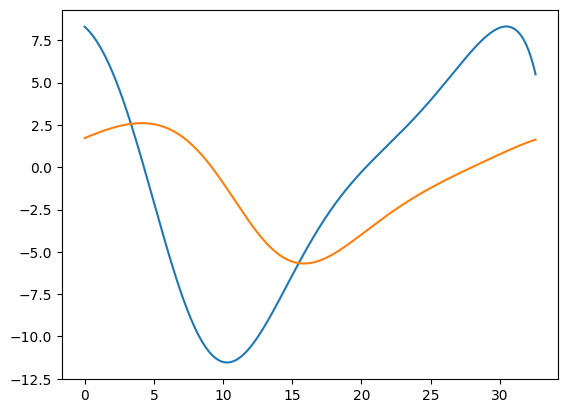

In [18]:
#ALL THIS COMPUTATITIONS ARE INTRINSIC OF THE OSCILLATOR (do not depend on theta,T,A)
# The following code implements the computation of the iPRC.


x_0 = P_1  # Initial condition for the periodic orbit (assumed to be defined)

t = np.linspace(0, Period, 1000)

# Integrate the periodic orbit
orbit_solution = odeint(neural_network_notperturbed, x_0, t, atol=atol, rtol=rtol)
interp_orbit_oscillator = interp1d(t, orbit_solution.T, kind='cubic', fill_value='extrapolate')

# Initial condition for the fundamental matrix (identity matrix)
A0 = np.eye(13).flatten()
t_vals = np.linspace(0, Period, 1000)

# Integrate the adjoint equation for the fundamental matrix
sol = odeint(adjoint_equation, A0, t_vals, args=(interp_orbit_oscillator,), atol=atol, rtol=rtol)
A_T = sol[-1].reshape(13, 13)
eigenvalues, eigenvectors = np.linalg.eig(A_T)
print(eigenvalues)
real_eigenvalues = np.real(eigenvalues)
closest_index = np.argmin(np.abs(real_eigenvalues - 1))
print(closest_index)
v_0 = np.real(eigenvectors[:, closest_index])
alpha = 1 / (v_0 @ neural_network_notperturbed(x_0, 0))
V_0 = alpha * v_0

t_vals = np.linspace(0, Period, 1000)
sol = odeint(adjoint_equation, A0, t_vals, args=(interp_orbit_oscillator,), atol=atol, rtol=rtol)
# Integrate the adjoint equation for the phase response curve
sol_phi_t = odeint(vector_adjoint_equation, V_0, t_vals, args=(interp_orbit_oscillator,), atol=atol, rtol=rtol)
interp_orbit_iPRC = interp1d(t_vals, sol_phi_t.T, kind='cubic', fill_value='extrapolate')
# Reshape sol into 3D array (len(t_vals), 13, 13)
sol_reshaped = sol.reshape(len(t_vals), 13, 13)

# Multiply each reshaped matrix by V_0
INTERP_IPRC = np.array([A @ V_0 for A in sol_reshaped])

#plt.plot(t_vals[0:6000],sol_phi_t[0:6000,1],label=r'$iPRC-V_e$')
#plt.plot(t_vals[0:6000],sol_phi_t[0:6000,5],label=r'$iPRC-V_i$')
#plt.plot(t_vals,sol_phi_t[0:500,1]+sol_phi_t[0:500,5],label=r'$iPRC-V_i$')
plt.plot(t_vals,sol_phi_t[:,1],label=r'$iPRC-V_e$')
plt.plot(t_vals,sol_phi_t[:,5],label=r'$iPRC-V_i$')

In [19]:
# Define the stroboscopic map function with updated parameters (x, A, T)
def stroboscopic_map(x, A, T,interp_orbit_iPRC):

    # Integrate the phase equation with the initial condition x
    t_phase = np.linspace(0, T, 1000)
    sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
    Theta_n = sol_theta_t[-1] % Period

    return Theta_n[0] #to ensure that it is an scalar



theta_n=18
#print(T/Period)
for i in range(1,50):
  theta_n=stroboscopic_map(theta_n,0.05,0.95*Period, interp_orbit_iPRC)
  print(theta_n)

7.368764207002883
4.4871652599229535
4.17857467382283
4.145257122439141
4.141632689615427
4.141238054844273
4.141195081998227
4.141190402543522
4.141189893049024
4.141189837518951
4.141189831463805
4.1411898308346125
4.14118983065989
4.141189830706146
4.141189830764645
4.1411898306984085
4.141189830724976
4.1411898307759785
4.141189830753554
4.141189830723619
4.141189830687807
4.141189830684638
4.1411898306696955
4.141189830705272
4.14118983072121
4.141189830732117
4.141189830684638
4.1411898306696955
4.141189830705272
4.14118983072121
4.141189830732117
4.141189830684638
4.1411898306696955
4.141189830705272
4.14118983072121
4.141189830732117
4.141189830684638
4.1411898306696955
4.141189830705272
4.14118983072121
4.141189830732117
4.141189830684638
4.1411898306696955
4.141189830705272
4.14118983072121
4.141189830732117
4.141189830684638
4.1411898306696955
4.141189830705272


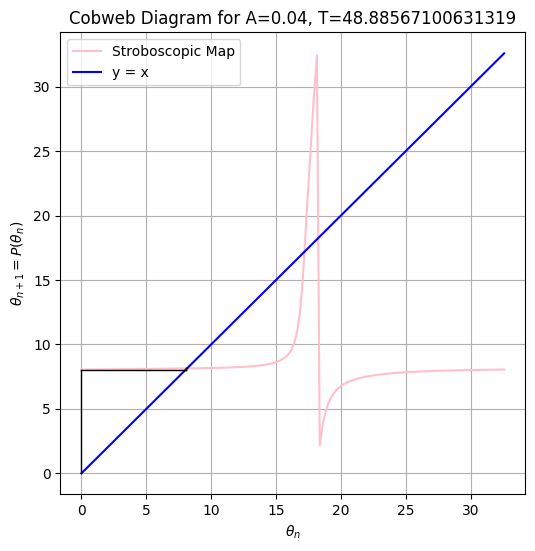

In [25]:
# Let us define a function to generate a COBWEB plot
def cobweb_plot(x0, T, A, num_steps):
    # Prepare the figure
    plt.figure(figsize=(6, 6))

    # Define the range for x values
    x= np.linspace(0, Period, 150)
    #x1 = np.linspace(0, 18.1, 100)
    #x2=np.linspace(18.4,Period,100)
    y = [stroboscopic_map(val, A, T, interp_orbit_iPRC) for val in x]  # Map values for y-axis
    #y2 = [stroboscopic_map(val, A, T, interp_orbit_iPRC) for val in x2]  # Map values for y-axis

    # Plot y = f(x) and y = x
    plt.plot(x, y, label='Stroboscopic Map', color='pink')
    #plt.plot(x2, y2, color='pink')
    plt.plot(x, x, label='y = x', color='blue')

    # Plot the cobweb diagram
    x_n = x0
    for _ in range(num_steps):
        x_next = stroboscopic_map(x_n, A, T, interp_orbit_iPRC)  # compute the following point

        # Vertical line (x_n, f(x_n))
        plt.plot([x_n, x_n], [x_n, x_next], color='black', lw=1)

        # Horizontal line (f(x_n), x_{n+1})
        plt.plot([x_n, x_next], [x_next, x_next], color='black', lw=1)

        # Update to the next point
        x_n = x_next

    # Add plot details
    plt.title(f'Cobweb Diagram for A={A}, T={T}')
    plt.xlabel(r'$\theta_n$')
    plt.ylabel(r'$\theta_{n+1} = P(\theta_n)$')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example call to the function with initial parameters
cobweb_plot(0, 1.5*Period, 0.04, 10)


### Computation of Arnold Tongues for $\kappa=\infty$

10.021063374332337
-13.951175548783475


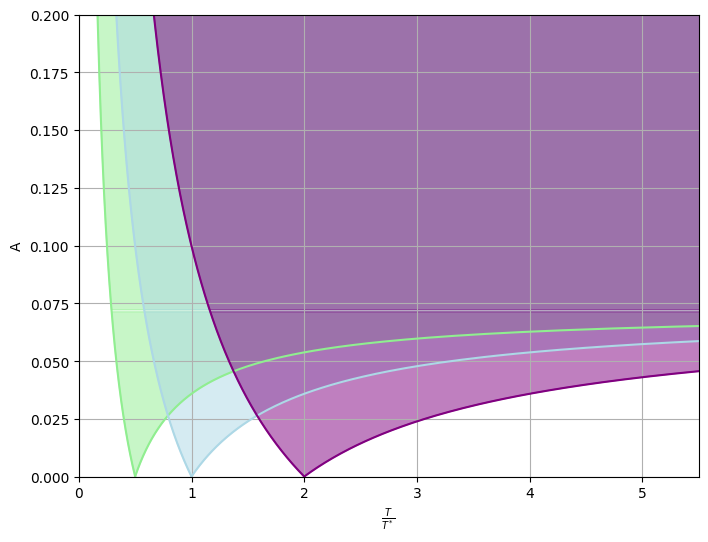

In [19]:
# The following code calculates the 1:1 and 2:1 Arnold tongues for pulsatile inputs.

time_points = np.linspace(0, Period, 1000)  # Sample points across one period
interp_values = interp_orbit_iPRC(time_points)  # Evaluate interp_orbit_iPRC over these points

# Extract components 1 and 5, and calculate their sum
Z_values = interp_values[1] + interp_values[5]  # Sum of component 1 and component 5

# Calculate Zmax and Zmin
Zmax = np.max(Z_values)
Zmin = np.min(Z_values)
print(Zmax)
print(Zmin)

# Define the range for A and calculate corresponding T/T* values
A_values = np.linspace(0, 0.2, 500)
T_over_Tstar_max = 1 + A_values * Zmax
T_over_Tstar_min = 1 + A_values * Zmin

T_over_Tstar_max_2 = (1/2)*(1 + A_values * Zmax)
T_over_Tstar_min_2 = (1/2)*(1 + A_values * Zmin)


T_over_Tstar_max = T_over_Tstar_max[T_over_Tstar_max > 0]
T_over_Tstar_min = T_over_Tstar_min[T_over_Tstar_min > 0]

T_over_Tstar_max_2 = T_over_Tstar_max_2[T_over_Tstar_max_2 > 0]
T_over_Tstar_min_2 = T_over_Tstar_min_2[T_over_Tstar_min_2 > 0]

# Plotting
plt.figure(figsize=(8, 6))
fill = np.full(len(A_values), 10)


plt.fill_betweenx(A_values[:len(T_over_Tstar_min)], 1 / T_over_Tstar_min[:len(T_over_Tstar_min)], 1 / T_over_Tstar_max[:len(T_over_Tstar_min)], color='lightblue', alpha=0.5, label='Region (blue)')
plt.fill_betweenx(A_values[len(T_over_Tstar_min)+1:], 1 / T_over_Tstar_max[len(T_over_Tstar_min)+1:],fill[len(T_over_Tstar_min)+1:], color='lightblue', alpha=0.5, label='Region (blue)')
# Plot the boundary lines for the filled region
plt.plot(1/T_over_Tstar_max, A_values[:len(T_over_Tstar_max)], color='lightblue')
plt.plot(1/T_over_Tstar_min, A_values[:len(T_over_Tstar_min)], color='lightblue')


plt.fill_betweenx(A_values[:len(T_over_Tstar_min_2)], 1 / T_over_Tstar_min_2[:len(T_over_Tstar_min_2)], 1 / T_over_Tstar_max_2[:len(T_over_Tstar_min_2)], color='purple', alpha=0.5)
plt.fill_betweenx(A_values[len(T_over_Tstar_min_2)+1:], 1 / T_over_Tstar_max_2[len(T_over_Tstar_min_2)+1:],fill[len(T_over_Tstar_min_2)+1:], color='purple', alpha=0.5)


# Plot the boundary lines for the filled region
plt.plot(1/T_over_Tstar_max_2, A_values[:len(T_over_Tstar_max_2)], color='purple')
plt.plot(1/T_over_Tstar_min_2, A_values[:len(T_over_Tstar_min_2)], color='purple')



# Setting limits for the axes
plt.xlim(0, 5.5)
plt.ylim(0, 0.2)

# Labels and title
plt.xlabel(r'$\frac{T}{T^*}$')
plt.ylabel("A")

plt.grid(True)

plt.show()

In [ ]:
# The following code implements the stroboscopic map for pulsatile inputs. 
#It will help us numerically calculate the 1:2 Arnold tongue as kappa tends to infinity.

def poincare_map(x, A, T,interp_orbit_iPRC):
    val=interp_orbit_iPRC(x)
    val=val[1]+val[5]
    return (x+T+A*T*val)%Period

def poincare_map_2(x,A,T,interp_orbit_iPRC):
    x1=poincare_map(x, A, T,interp_orbit_iPRC)
    x2=poincare_map(x1, A, T,interp_orbit_iPRC)
    return x2

In [ ]:
# Let us define a function to generate a COBWEB plot
def cobweb_plot_squared(x0, T, A, num_steps):
    # Prepare the figure
    plt.figure(figsize=(6, 6))

    # Define the range for x values
    x = np.linspace(0, Period, 100)
    y = [poincare_map_2(val,A,T, interp_orbit_iPRC) for val in x]  # Map values for y-axis
   

    # Plot y = f(x) and y = x
    plt.plot(x, y, label='Stroboscopic 5 Map', color='pink')
    
    plt.plot(x, x, label='y = x', color='blue')

     # Plot the cobweb diagram
    x_n = x0
    for _ in range(num_steps):
        x_next = poincare_map_2(x_n,A,T, interp_orbit_iPRC)  # compute the following point

        # Vertical line (x_n, f(x_n))
        plt.plot([x_n, x_n], [x_n, x_next], color='black', lw=1)

        # Horizontal line (f(x_n), x_{n+1})
        plt.plot([x_n, x_next], [x_next, x_next], color='black', lw=1)

        # Update to the next point
        x_n = x_next

    # Add plot details
    plt.title(f'Cobweb Diagram for A={A}, T={T}')
    plt.xlabel(r'$\theta_n$')
    plt.ylabel(r'$\theta_{n+1} = P(\theta_n)$')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example call to the function with initial parameters
cobweb_plot_squared(0, 0.5913*Period, 0.025, 100)


In [ ]:
# The following code helps us find a point on the boundary of the Arnold tongue.

import numpy as np
from scipy.optimize import fsolve
import numdifftools as nd

def derivative_stroboscopic_map_analytic(theta, A, T, interp_orbit_iPRC):
    stroboscopic_map_theta = lambda theta: poincare_map_2(theta, A, T, interp_orbit_iPRC)
    dPhi_dtheta = nd.Derivative(stroboscopic_map_theta)(theta)
    return dPhi_dtheta

# Set T to be 95% of the period
T = 0.5913*Period

# Initial guess for [theta, A]
initial_guess = [22, 0.025]

# Define the function to find roots for [theta, A] given a fixed T
def phase_conditions_root(vars):
    theta, A = vars  # Unpack variables

   
    Phi_T = poincare_map_2(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    
    dPhi_dtheta = derivative_stroboscopic_map_analytic(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])

# Use fsolve to find a root, starting from the initial guess
solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

# Extract the result
theta_solution, A_solution = solution.x

# Check conditions by evaluating phase_conditions_root at the solution
cond1, cond2 = phase_conditions_root([theta_solution, A_solution])

# Output the solution and the values of the conditions
print("Solution found:")
print(f"theta = {theta_solution}")
print(f"A = {A_solution}")
print("\nVerification of conditions:")
print(f"Condition 1 (Phi_T - theta): {cond1}")
print(f"Condition 2 (dPhi/dT - 1): {cond2}")

# Check if both conditions are close to zero
tolerance = 1e-6
if abs(cond1) < tolerance and abs(cond2) < tolerance:
    print("\nBoth conditions are satisfied within the specified tolerance.")
else:
    print("\nWarning: One or both conditions are not satisfied within the specified tolerance.")


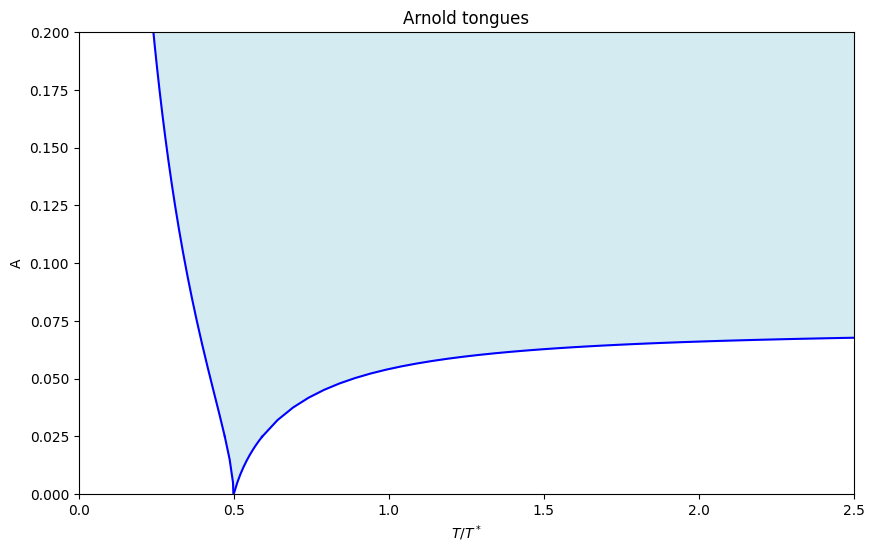

In [43]:
# The following code calculates the 1:2 Arnold tongue for pulsatile inputs. 
#The explanation of the method can be found in the appendix of the written thesis.
num_iterations_up_r = 20  # Number of iterations you want

# Initialize lists to store results
T_values_right = []
A_values_right = []

# Initialize T to 95% of Period
A = 0.025

# Initial conditions
initial_guess = [19.79, 0.4725*Period]

# Function to find roots
def phase_conditions_root(vars):
    theta, T = vars  # Unpack variables

    # Evaluate the stroboscopic map
    Phi_T = poincare_map_2(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    # Derivative with respect to theta
    dPhi_dtheta = derivative_stroboscopic_map_analytic(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])

# Loop to iterate and find new points
for i in range(num_iterations_up_r):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract results
    theta_solution, T_solution = solution.x

    # Store values in the lists
    T_values_right.append(T_solution / Period)  # Store normalized T
    A_values_right.append(A)    # Store A

    #print(T/Period)
    # Prepare the new T
    A += 0.01  # Increment A
    initial_guess = [theta_solution, T_solution]  # Use the found solution as the new initial point

num_iterations_down_r = 5
A = 0.025
# Initial conditions
initial_guess = [19.79, 0.4725*Period]

# Loop to iterate and find new points
for i in range(num_iterations_down_r):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract results
    theta_solution, T_solution = solution.x

    # Store values in the lists
    T_values_right.append(T_solution / Period)  # Store normalized T
    A_values_right.append(A)    # Store A

    #print(T/Period)
    # Prepare the new T
    A -= 0.01  # Decrement A
    initial_guess = [theta_solution, T_solution]  # Use the found solution as the new initial point


# Set the increment h

num_iterations_up_left = 50  # Number of iterations you want
def phase_conditions_root(vars):
    theta, A = vars  # Unpack variables

    # Evaluate the stroboscopic map
    Phi_T = poincare_map_2(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    # Derivative with respect to theta
    dPhi_dtheta = derivative_stroboscopic_map_analytic(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])
# Initialize lists to store results
T_values = []
A_values = []

# Initialize T to 95% of Period
T = 0.5913*Period

# Initial conditions
initial_guess = [23.73, 0.025]

# Loop to iterate and find new points
for i in range(num_iterations_up_left):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract results
    theta_solution, A_solution = solution.x

    # Store values in the lists
    T_values.append(T / Period)  # Store normalized T
    A_values.append(A_solution)    # Store A

    #print(T/Period)
    # Prepare the new T
    T += 0.05*Period  # Increment T
    initial_guess = [theta_solution, A_solution]  # Use the found solution as the new initial point

num_iterations_down_left = 10
T = 0.5913*Period
# Initial conditions
initial_guess = [23.73, 0.025]


# Loop to iterate and find new points
for i in range(num_iterations_down_left):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract results
    theta_solution, A_solution = solution.x

    # Store values in the lists
    T_values.append(T / Period)  # Store normalized T
    A_values.append(A_solution)    # Store A

    #print(T/Period)
    # Prepare the new T
    T -= 0.01*Period  # Decrement T
    initial_guess = [theta_solution, A_solution]  # Use the found solution as the new initial point


# Create a common set of points for the y-axis (A), for example, from 0 to 0.2
A_common = np.linspace(0, 0.2, 200)

# Interpolate both curves for these common points in terms of A
interp_left = interp1d(A_values, T_values, bounds_error=False, fill_value="extrapolate")
interp_right = interp1d(A_values_right, T_values_right, bounds_error=False, fill_value="extrapolate")

# Evaluate both interpolations at the common A points
T_values_left_interp = interp_left(A_common)
T_values_right_interp = interp_right(A_common)

# Plot the original curves
plt.figure(figsize=(10, 6))
plt.xlim(0, 2.5)
plt.ylim(0, 0.2)
plt.plot(T_values_right[0:num_iterations_up_r], A_values_right[0:num_iterations_up_r], color='blue')
plt.plot(T_values_right[num_iterations_up_r:], A_values_right[num_iterations_up_r:], color='blue')
plt.plot(T_values[0:num_iterations_up_left], A_values[0:num_iterations_up_left], color='blue')
plt.plot(T_values[num_iterations_up_left:], A_values[num_iterations_up_left:], color='blue')

# Fill the area between the two interpolated curves
plt.fill_betweenx(A_common, T_values_left_interp, T_values_right_interp, color='lightblue', alpha=0.5)

# Labels and additional settings
plt.xlabel(r'$T/T^*$')
plt.ylabel('A')
plt.title('Arnold tongues')
plt.grid(False)
plt.show()

# Saving data to .npy files
np.save("A_common.npy", A_common)
np.save("T_values_left_interp_eii_1_2_inf.npy", T_values_left_interp)
np.save("T_values_right_interp_eii_1_2_inf.npy", T_values_right_interp)


### Computation of Arnold tongues for $\kappa \neq \infty$

In [22]:
import numpy as np
from scipy.optimize import fsolve
# Suponiendo que T y A están definidos
# Ejemplo: T = 1.0, A = 0.05 (ajusta a los valores deseados)
T = 2.81*Period
A = 0.025

stroboscopic_map_theta = lambda theta: stroboscopic_map(theta, A, T, interp_orbit_iPRC)


def fixed_point_condition(theta):
    return stroboscopic_map_theta(theta) - theta


initial_theta = 10  

theta_solution = fsolve(fixed_point_condition, initial_theta)[0]

print("Valor de theta encontrado:", theta_solution)

verificacion = fixed_point_condition(theta_solution)
print("Verificación (debe ser cercano a 0):", verificacion)


Valor de theta encontrado: 11.683475456900423
Verificación (debe ser cercano a 0): -3.8125946844047576e-11


In [25]:
import numpy as np
from scipy.optimize import fsolve

def derivative_stroboscopic_map(theta, A, T, interp_orbit_iPRC):
    stroboscopic_map_theta = lambda theta: stroboscopic_map(theta, A, T, interp_orbit_iPRC)
    dPhi_dtheta = nd.Derivative(stroboscopic_map_theta)(theta)
    return dPhi_dtheta

# Set T to be 95% of the period
A=0.01
# Initial guess for [theta, T]
initial_guess = [28, 1.99*Period]

# Define the function to find roots for [theta, A] given a fixed T
def phase_conditions_root_A(vars):
    theta, T = vars  # Unpack variables

    
    Phi_T = stroboscopic_map(theta,A,T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    
    dPhi_dtheta = derivative_stroboscopic_map(theta,A,T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])

# Use fsolve to find a root, starting from the initial guess
solution = root(phase_conditions_root_A, initial_guess, method='hybr', tol=1e-8)

# Extract the result
theta_solution, T_solution = solution.x

# Check conditions by evaluating phase_conditions_root at the solution
cond1, cond2 = phase_conditions_root_A([theta_solution, T_solution])

# Output the solution and the values of the conditions
print("Solution found:")
print(f"theta = {theta_solution}")
print(f"T/T^* = {T_solution/Period}")
print("\nVerification of conditions:")
print(f"Condition 1 (Phi_T - theta): {cond1}")
print(f"Condition 2 (dPhi/dT - 1): {cond2}")

# Check if both conditions are close to zero
tolerance = 1e-6
if abs(cond1) < tolerance and abs(cond2) < tolerance:
    print("\nBoth conditions are satisfied within the specified tolerance.")
else:
    print("\nWarning: One or both conditions are not satisfied within the specified tolerance.")

Solution found:
theta = 29.541053730129406
T/T^* = 1.9910413447638624

Verification of conditions:
Condition 1 (Phi_T - theta): -5.33674437974696e-10
Condition 2 (dPhi/dT - 1): -1.80354797763016e-09

Both conditions are satisfied within the specified tolerance.


In [252]:
import numpy as np
from scipy.optimize import fsolve

def derivative_stroboscopic_map(theta, A, T, interp_orbit_iPRC):
    stroboscopic_map_theta = lambda theta: stroboscopic_map(theta, A, T, interp_orbit_iPRC)
    dPhi_dtheta = nd.Derivative(stroboscopic_map_theta)(theta)
    return dPhi_dtheta

# Set T to be 95% of the period
T=1.45*Period
# Initial guess for [theta, A]
initial_guess = [11.29,0.025]

# Define the function to find roots for [theta, A] given a fixed T

def phase_conditions_root(vars):
    theta, A = vars  # Unpack variables

    
    Phi_T = stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

   
    dPhi_dtheta = derivative_stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])
# Use fsolve to find a root, starting from the initial guess
solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

# Extract the result
theta_solution, A_solution = solution.x

# Check conditions by evaluating phase_conditions_root at the solution
cond1, cond2 = phase_conditions_root([theta_solution, A_solution])

# Output the solution and the values of the conditions
print("Solution found:")
print(f"theta = {theta_solution}")
print(f"A = {A_solution}")
print("\nVerification of conditions:")
print(f"Condition 1 (Phi_T - theta): {cond1}")
print(f"Condition 2 (dPhi/dT - 1): {cond2}")

# Check if both conditions are close to zero
tolerance = 1e-6
if abs(cond1) < tolerance and abs(cond2) < tolerance:
    print("\nBoth conditions are satisfied within the specified tolerance.")
else:
    print("\nWarning: One or both conditions are not satisfied within the specified tolerance.")

Solution found:
theta = 12.312032564650181
A = 0.024458704022390365

Verification of conditions:
Condition 1 (Phi_T - theta): -1.3141772114977357e-09
Condition 2 (dPhi/dT - 1): -1.0490186497236209e-10

Both conditions are satisfied within the specified tolerance.


In [ ]:
#COMPUTATION OF THE 1:1 ARNOLD TONGUE
# Set the step increment h
h = 0.001  # The step size you desire
num_iterations_up_r = 60  # Number of iterations you want

# Initialize lists to store results
T_values_right = []
A_values_right = []

# Initialize T to 95% of Period
A = 0.05

# Initial conditions
initial_guess = [28.9206, 0.857*Period]

# Function to find roots
def phase_conditions_root(vars):
    theta, T = vars  # Unpack variables

    # Evaluate the stroboscopic map
    Phi_T = stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    # Derivative with respect to theta
    dPhi_dtheta = derivative_stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])

# Loop to iterate and find new points
for i in range(num_iterations_up_r):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract results
    theta_solution, T_solution = solution.x

    # Store values in the lists
    T_values_right.append(T_solution / Period)  # Store normalized T
    A_values_right.append(A)    # Store A

    # Prepare the new T
    A -= 0.001  # Decrease A
    initial_guess = [theta_solution, T_solution]  # Use the found solution as the new initial point

num_iterations_down_r = 155
A = 0.05

# Initial conditions
initial_guess = [28.9206, 0.857*Period]

# Loop to iterate and find new points
for i in range(num_iterations_down_r):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract results
    theta_solution, T_solution = solution.x

    # Store values in the lists
    T_values_right.append(T_solution / Period)  # Store normalized T
    A_values_right.append(A)    # Store A

    # Prepare the new T
    A += 0.001  # Increase A
    initial_guess = [theta_solution, T_solution]  # Use the found solution as the new initial point


# Set the step increment h
h = 0.01  # The step size you desire
num_iterations_up_left = 110  # Number of iterations you want

# Initialize lists to store results
T_values = []
A_values = []

# Initialize T to 95% of Period
T = 1.45 * Period

# Initial conditions
initial_guess = [11.29, 0.025]

# Loop to iterate and find new points
for i in range(num_iterations_up_left):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract results
    theta_solution, A_solution = solution.x

    # Store values in the lists
    T_values.append(T / Period)  # Store normalized T
    A_values.append(A_solution)    # Store A

    # Prepare the new T
    T += h * Period  # Increase T
    initial_guess = [theta_solution, A_solution]  # Use the found solution as the new initial point

num_iterations_down_left = 25
T = 1.45 * Period
# Initial conditions
initial_guess = [11.29, 0.025]

# Loop to iterate and find new points
for i in range(num_iterations_down_left):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract results
    theta_solution, A_solution = solution.x

    # Store values in the lists
    T_values.append(T / Period)  # Store normalized T
    A_values.append(A_solution)    # Store A

    # Prepare the new T
    T -= h * Period  # Decrease T
    initial_guess = [theta_solution, A_solution]  # Use the found solution as the new initial point


# Create a common set of points for the y-axis (A), for example, from 0 to 0.2
A_common = np.linspace(0, 0.2, 200)

# Interpolate both curves for these common points in terms of A
interp_left = interp1d(A_values, T_values, bounds_error=False, fill_value="extrapolate")
interp_right = interp1d(A_values_right, T_values_right, bounds_error=False, fill_value="extrapolate")

# Evaluate both interpolations at the common A points
T_values_left_interp = interp_left(A_common)
T_values_right_interp = interp_right(A_common)

# Plot the original curves
plt.figure(figsize=(10, 6))
plt.xlim(0, 2.5)
plt.ylim(0, 0.2)
plt.plot(T_values_right[0:num_iterations_up_r], A_values_right[0:num_iterations_up_r], color='blue')
plt.plot(T_values_right[num_iterations_up_r:], A_values_right[num_iterations_up_r:], color='blue')
plt.plot(T_values[0:num_iterations_up_left], A_values[0:num_iterations_up_left], color='blue')
plt.plot(T_values[num_iterations_up_left:], A_values[num_iterations_up_left:], color='blue')

# Fill the area between the two interpolated curves
plt.fill_betweenx(A_common, T_values_left_interp, T_values_right_interp, color='lightblue', alpha=0.5)

# Labels and additional settings
plt.xlabel(r'$T/T^*$')
plt.ylabel('A')
plt.title('Arnold tongues')
plt.grid(False)
plt.show()

# Saving data to .npy files
np.save("A_common.npy", A_common)
np.save("T_values_left_interp_I.npy", T_values_left_interp)
np.save("T_values_right_interp_I.npy", T_values_right_interp)


0.05
0.049
0.048
0.047
0.046
0.045
0.044
0.043
0.041999999999999996
0.040999999999999995
0.039999999999999994
0.03899999999999999
0.03799999999999999
0.03699999999999999
0.03599999999999999
0.03499999999999999
0.03399999999999999
0.03299999999999999
0.03199999999999999
0.030999999999999986
0.029999999999999985
0.028999999999999984
0.027999999999999983
0.026999999999999982
0.02599999999999998
0.02499999999999998
0.02399999999999998
0.02299999999999998
0.021999999999999978
0.020999999999999977
0.019999999999999976
0.018999999999999975
0.017999999999999974
0.016999999999999973
0.015999999999999973
0.014999999999999972
0.01399999999999997
0.01299999999999997
0.011999999999999969
0.010999999999999968
0.009999999999999967
0.008999999999999966
0.007999999999999965
0.0069999999999999655
0.005999999999999965
0.004999999999999965
0.003999999999999965
0.0029999999999999654
0.0019999999999999653
0.0009999999999999653
0.05
0.051000000000000004
0.052000000000000005
0.053000000000000005
0.05400000000

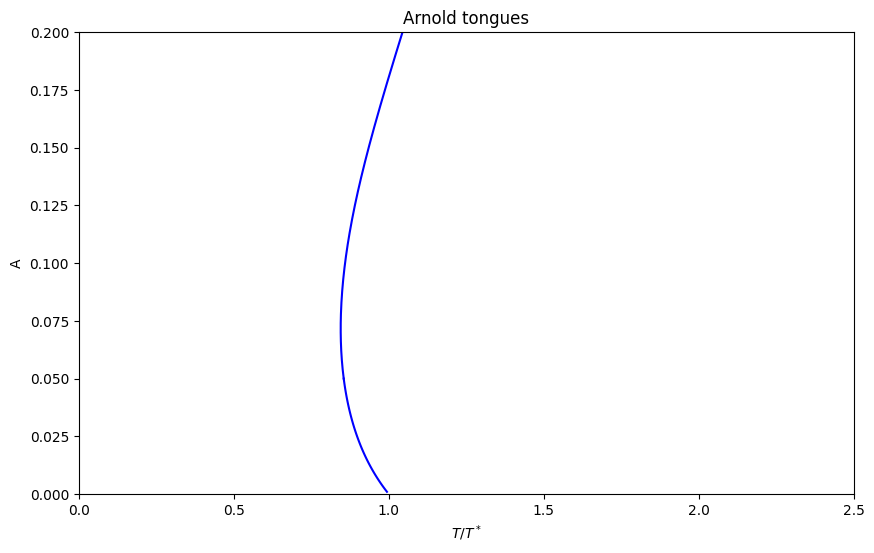

In [91]:
# Set the step increment h
h = 0.001  # The step size you desire
num_iterations_up_r = 50  # Number of iterations you want

# Initialize lists to store results
T_values_right = []
A_values_right = []

# Initialize T to 95% of Period
A = 0.05

# Initial conditions
initial_guess = [28.9206, 0.857*Period]

# Function to find roots
def phase_conditions_root(vars):
    theta, T = vars  # Unpack variables

    # Evaluate the stroboscopic map
    Phi_T = stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    # Derivative with respect to theta
    dPhi_dtheta = derivative_stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])

# Loop to iterate and find new points
for i in range(num_iterations_up_r):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract results
    theta_solution, T_solution = solution.x

    # Store values in the lists
    T_values_right.append(T_solution / Period)  # Store normalized T
    A_values_right.append(A)    # Store A

    print(A)
    # Prepare the new T
    A -= 0.001  # Decrease A
    initial_guess = [theta_solution, T_solution]  # Use the found solution as the new initial point

num_iterations_down_r = 151
A = 0.05

# Initial conditions
initial_guess = [28.9206, 0.857*Period]

# Loop to iterate and find new points
for i in range(num_iterations_down_r):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract results
    theta_solution, T_solution = solution.x

    # Store values in the lists
    T_values_right.append(T_solution / Period)  # Store normalized T
    A_values_right.append(A)    # Store A

    print(A)
    # Prepare the new T
    A += 0.001  # Increase A
    initial_guess = [theta_solution, T_solution]  # Use the found solution as the new initial point


# Create a common set of points for the y-axis (A), for example, from 0 to 0.2
A_common = np.linspace(0, 0.2, 200)

# Interpolate the right curve for these common points in terms of A
interp_right = interp1d(A_values_right, T_values_right, bounds_error=False, fill_value="extrapolate")

# Evaluate the interpolation at the common A points
T_values_right_interp = interp_right(A_common)

# Plot the original curves
plt.figure(figsize=(10, 6))
plt.xlim(0, 2.5)
plt.ylim(0, 0.2)
plt.plot(T_values_right[0:num_iterations_up_r], A_values_right[0:num_iterations_up_r], color='blue')
plt.plot(T_values_right[num_iterations_up_r:], A_values_right[num_iterations_up_r:], color='blue')

# Labels and additional settings
plt.xlabel(r'$T/T^*$')
plt.ylabel('A')
plt.title('Arnold tongues')
plt.grid(False)
plt.show()

# Saving data to .npy files
np.save("A_common.npy", A_common)
np.save("T_values_right_interp_I.npy", T_values_right_interp)


0.01
0.0095
0.009
0.008499999999999999
0.007999999999999998
0.007499999999999998
0.0069999999999999975
0.006499999999999997
0.005999999999999997
0.005499999999999996
0.004999999999999996
0.004499999999999995
0.003999999999999995
0.003499999999999995
0.002999999999999995
0.002499999999999995
0.001999999999999995
0.0014999999999999948
0.0009999999999999948
0.0004999999999999948
0.01
0.0105
0.011000000000000001
0.011500000000000002
0.012000000000000002
0.012500000000000002
0.013000000000000003
0.013500000000000003
0.014000000000000004
0.014500000000000004
0.015000000000000005
0.015500000000000005
0.016000000000000004
0.016500000000000004
0.017000000000000005
0.017500000000000005
0.018000000000000006
0.018500000000000006
0.019000000000000006
0.019500000000000007
0.020000000000000007
0.020500000000000008
0.021000000000000008
0.02150000000000001
0.02200000000000001
0.02250000000000001
0.02300000000000001
0.02350000000000001
0.02400000000000001
0.02450000000000001
0.025000000000000012
0.02550

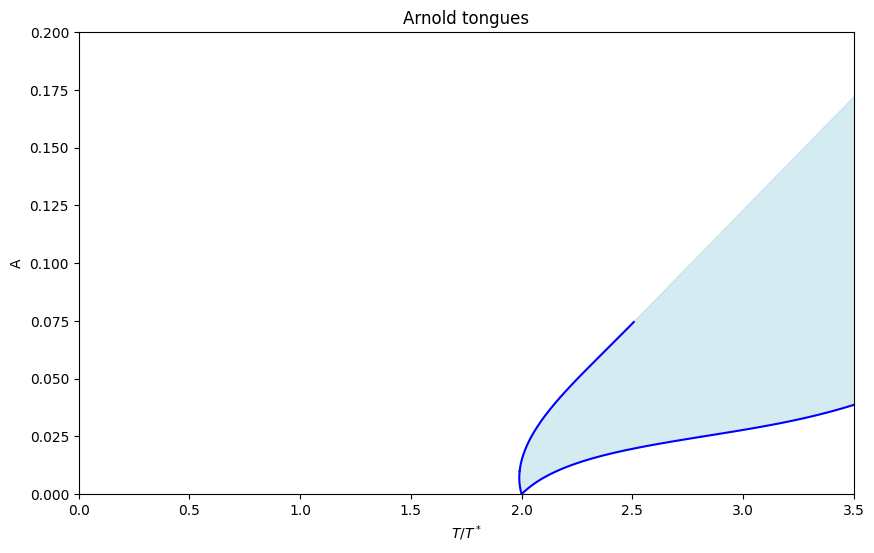

In [63]:
#COMPUTATION OF THE 2:1 ARNOLD TONGUE
# Set the step increment h
h = 0.001  # The step size you desire
num_iterations_up_r = 20  # Number of iterations you want

# Initialize lists to store results
T_values_right_2 = []
A_values_right_2 = []

# Initialize T to 95% of Period
A = 0.01

# Initial conditions
initial_guess = [29.54, 1.99*Period]

# Function to find roots
def phase_conditions_root(vars):
    theta, T = vars  # Unpack variables

    # Evaluate the stroboscopic map
    Phi_T = stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    # Derivative with respect to theta
    dPhi_dtheta = derivative_stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])

# Loop to iterate and find new points
for i in range(num_iterations_up_r):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract results
    theta_solution, T_solution = solution.x

    # Store values in the lists
    T_values_right_2.append(T_solution / Period)  # Store normalized T
    A_values_right_2.append(A)    # Store A
    
    print(A)
    # Prepare the new T
    A -= 0.0005  # Decrease A
    initial_guess = [theta_solution, T_solution]  # Use the found solution as the new initial point

num_iterations_down_r = 130
A = 0.01

# Initial conditions
initial_guess = [29.54, 1.99*Period]

# Loop to iterate and find new points
for i in range(num_iterations_down_r):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract results
    theta_solution, T_solution = solution.x

    # Store values in the lists
    T_values_right_2.append(T_solution / Period)  # Store normalized T
    A_values_right_2.append(A)    # Store A

    print(A)
    # Prepare the new T
    A += 0.0005  # Increase A
    initial_guess = [theta_solution, T_solution]  # Use the found solution as the new initial point


# Create a common set of points for the y-axis (A), for example, from 0 to 0.2
A_common = np.linspace(0, 0.2, 200)

# Interpolate the right curve for these common points in terms of A
interp_right = interp1d(A_values_right_2, T_values_right_2, bounds_error=False, fill_value="extrapolate")

# Evaluate the interpolation at the common A points
T_values_right_interp_2_I = interp_right(A_common)

# Function to find roots for A
def phase_conditions_root_A(vars):
    theta, A = vars  # Unpack variables

    # Evaluate the stroboscopic map
    Phi_T = stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    # Derivative with respect to theta
    dPhi_dtheta = derivative_stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])


# Set the step increment h
h = 0.02  # The step size you desire
num_iterations_up_left = 40  # Number of iterations you want

# Initialize lists to store results
T_values_2_I = []
A_values_2_I = []

T = 2.81 * Period
# Initial conditions
initial_guess = [12.31, 0.025]

# Loop to iterate and find new points
for i in range(num_iterations_up_left):
    # Use fsolve to find a root
    solution = root(phase_conditions_root_A, initial_guess, method='hybr', tol=1e-8)

    # Extract results
    theta_solution, A_solution = solution.x

    # Store values in the lists
    T_values_2_I.append(T / Period)  # Store normalized T
    A_values_2_I.append(A_solution)    # Store A

    print(T / Period)
    # Prepare the new T
    T += h * Period  # Increase T
    initial_guess = [theta_solution, A_solution]  # Use the found solution as the new initial point

num_iterations_down_left = 42
T = 2.81 * Period
# Initial conditions
initial_guess = [12.31, 0.025]

# Loop to iterate and find new points
for i in range(num_iterations_down_left):
    # Use fsolve to find a root
    solution = root(phase_conditions_root_A, initial_guess, method='hybr', tol=1e-8)

    # Extract results
    theta_solution, A_solution = solution.x

    # Store values in the lists
    T_values_2_I.append(T / Period)  # Store normalized T
    A_values_2_I.append(A_solution)    # Store A

    print(T / Period)
    # Prepare the new T
    T -= h * Period  # Decrease T
    initial_guess = [theta_solution, A_solution]  # Use the found solution as the new initial point


# Create a common set of points for the y-axis (A), for example, from 0 to 0.2
A_common = np.linspace(0, 0.2, 200)

# Interpolate both curves for these common points in terms of A
interp_left = interp1d(A_values_2_I, T_values_2_I, bounds_error=False, fill_value="extrapolate")

# Evaluate both interpolations at the common A points
T_values_left_interp_2_I = interp_left(A_common)

# Saving data to .npy files
np.save("A_common.npy", A_common)
np.save("T_values_left_interp_2_I.npy", T_values_left_interp_2_I)

# Plot the original curves
plt.figure(figsize=(10, 6))
plt.xlim(0, 2.5)
plt.ylim(0, 0.2)
plt.plot(T_values_right_2[0:num_iterations_up_r], A_values_right_2[0:num_iterations_up_r], color='blue')
plt.plot(T_values_right_2[num_iterations_up_r:], A_values_right_2[num_iterations_up_r:], color='blue')
plt.plot(T_values_2_I[0:num_iterations_up_left], A_values_2_I[0:num_iterations_up_left], color='blue')
plt.plot(T_values_2_I[num_iterations_up_left:], A_values_2_I[num_iterations_up_left:], color='blue')

# Fill the area between the two interpolated curves
plt.fill_betweenx(A_common, T_values_left_interp_2_I, T_values_right_interp_2_I, color='lightblue', alpha=0.5)

# Labels and additional settings
plt.xlabel(r'$T/T^*$')
plt.ylabel('A')
plt.title('Arnold tongues')
plt.grid(False)
plt.show()

# Saving the right interpolated data to .npy file
np.save("T_values_right_interp_2_I.npy", T_values_right_interp_2_I)




In [42]:
# Define the function for P^2(theta) in order to find the 1:2 Arnold tongue
def stroboscopic_map_squared(x, A, T,interp_orbit_iPRC):
    # Apply stroboscopic_map twice
    first_application = stroboscopic_map(x, A, T, interp_orbit_iPRC)
    second_application = stroboscopic_map(first_application, A, T, interp_orbit_iPRC)
    return second_application

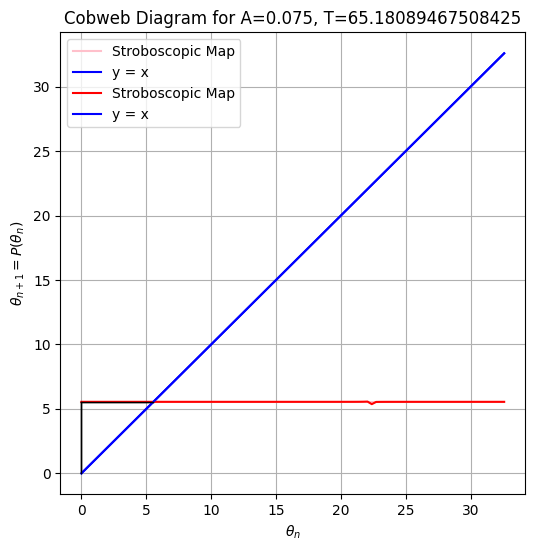

In [44]:

# Example call to the function with initial parameters
def cobweb_plot(x0, T, A, num_steps):
    # Prepare the figure
    plt.figure(figsize=(6, 6))

    # Define the range for x values
    x = np.linspace(0, Period, 100)
    y = [stroboscopic_map(val, A, T, interp_orbit_iPRC) for val in x]  # Map values for y-axis

    # Plot y = f(x) and y = x
    plt.plot(x, y, label='Stroboscopic Map', color='pink')
    plt.plot(x, x, label='y = x', color='blue')

    # Plot the cobweb diagram
    x_n = x0
    for _ in range(num_steps):
        x_next = stroboscopic_map(x_n, A, T, interp_orbit_iPRC)  # compute the following point

        # Vertical line (x_n, f(x_n))
        plt.plot([x_n, x_n], [x_n, x_next], color='black', lw=1)

        # Horizontal line (f(x_n), x_{n+1})
        plt.plot([x_n, x_next], [x_next, x_next], color='black', lw=1)

        # Update to the next point
        x_n = x_next

    # Add plot details
    plt.title(f'Cobweb Diagram for A={A}, T={T}')
    plt.xlabel(r'$\theta_n$')
    plt.ylabel(r'$\theta_{n+1} = P(\theta_n)$')
    plt.grid(True)
    plt.legend()
    plt.show()
    
def cobweb_plot_squared(x0, T, A, num_steps):
    # Prepare the figure
    plt.figure(figsize=(6, 6))

    # Define the range for x values
    x = np.linspace(0, Period, 100)
    y = [stroboscopic_map_squared(val, A, T, interp_orbit_iPRC) for val in x]  # Map values for y-axis

    # Plot y = f(x) and y = x
    plt.plot(x, y, label='Stroboscopic Map', color='pink')
    plt.plot(x, x, label='y = x', color='blue')

    # Plot the cobweb diagram
    x_n = x0
    for _ in range(num_steps):
        x_next = stroboscopic_map_squared(x_n, A, T, interp_orbit_iPRC)  # compute the following point

        # Vertical line (x_n, f(x_n))
        plt.plot([x_n, x_n], [x_n, x_next], color='black', lw=1)

        # Horizontal line (f(x_n), x_{n+1})
        plt.plot([x_n, x_next], [x_next, x_next], color='black', lw=1)

        # Update to the next point
        x_n = x_next
        
        
    x = np.linspace(0, Period, 100)
    y = [stroboscopic_map(val, A, T, interp_orbit_iPRC) for val in x]  # Map values for y-axis

    # Plot y = f(x) and y = x
    plt.plot(x, y, label='Stroboscopic Map', color='red')
    plt.plot(x, x, label='y = x', color='blue')

    # Plot the cobweb diagram
    x_n = x0
    for _ in range(num_steps):
        x_next = stroboscopic_map(x_n, A, T, interp_orbit_iPRC)  # compute the following point

        # Vertical line (x_n, f(x_n))
        plt.plot([x_n, x_n], [x_n, x_next], color='black', lw=1)

        # Horizontal line (f(x_n), x_{n+1})
        plt.plot([x_n, x_next], [x_next, x_next], color='black', lw=1)

        # Update to the next point
        x_n = x_next
    # Add plot details
    plt.title(f'Cobweb Diagram for A={A}, T={T}')
    plt.xlabel(r'$\theta_n$')
    plt.ylabel(r'$\theta_{n+1} = P(\theta_n)$')
    plt.grid(True)
    plt.legend()
    plt.show()
    
#cobweb_plot(0, Period, 0.05, 50)
cobweb_plot_squared(0, 2*Period, 0.075, 10)

In [66]:
import numpy as np
from scipy.optimize import fsolve

def derivative_stroboscopic_map_squared(theta, A, T, interp_orbit_iPRC):
    stroboscopic_map_theta_squared = lambda theta: stroboscopic_map_squared(theta, A, T, interp_orbit_iPRC)
    dPhi_dtheta = nd.Derivative(stroboscopic_map_theta_squared)(theta)
    return dPhi_dtheta

# Set T to be 95% of the period
T = 0.56*Period

# Initial guess for [theta, A]
initial_guess = [10, 0.025]

# Define the function to find roots for [theta, A] given a fixed T
def phase_conditions_root_squared(vars):
    theta, A = vars  # Unpack variables

    
    Phi_T = stroboscopic_map_squared(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    
    dPhi_dtheta = derivative_stroboscopic_map_squared(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])

# Use fsolve to find a root, starting from the initial guess
solution = root(phase_conditions_root_squared, initial_guess, method='hybr', tol=1e-8)

# Extract the result
theta_solution, A_solution = solution.x

# Check conditions by evaluating phase_conditions_root at the solution
cond1, cond2 = phase_conditions_root_squared([theta_solution, A_solution])

# Output the solution and the values of the conditions
print("Solution found:")
print(f"theta = {theta_solution}")
print(f"A = {A_solution}")
print("\nVerification of conditions:")
print(f"Condition 1 (Phi_T - theta): {cond1}")
print(f"Condition 2 (dPhi/dT - 1): {cond2}")

# Check if both conditions are close to zero
tolerance = 1e-6
if abs(cond1) < tolerance and abs(cond2) < tolerance:
    print("\nBoth conditions are satisfied within the specified tolerance.")
else:
    print("\nWarning: One or both conditions are not satisfied within the specified tolerance.")

Solution found:
theta = 10.317356757532405
A = 0.02467083623651337

Verification of conditions:
Condition 1 (Phi_T - theta): -1.212150380069943e-10
Condition 2 (dPhi/dT - 1): 1.2379406388873804e-09

Both conditions are satisfied within the specified tolerance.


0.025
0.024
0.023
0.022
0.020999999999999998
0.019999999999999997
0.018999999999999996
0.017999999999999995
0.016999999999999994
0.015999999999999993
0.014999999999999993
0.013999999999999992
0.01299999999999999
0.01199999999999999
0.010999999999999989
0.009999999999999988
0.008999999999999987
0.007999999999999986
0.006999999999999986
0.005999999999999986
0.004999999999999986
0.003999999999999986
0.002999999999999986
0.001999999999999986
0.0009999999999999861
0.025
0.026000000000000002
0.027000000000000003
0.028000000000000004
0.029000000000000005
0.030000000000000006
0.031000000000000007
0.03200000000000001
0.03300000000000001
0.03400000000000001
0.03500000000000001
0.03600000000000001
0.03700000000000001
0.03800000000000001
0.039000000000000014
0.040000000000000015
0.041000000000000016
0.042000000000000016
0.04300000000000002
0.04400000000000002
0.04500000000000002
0.04600000000000002
0.04700000000000002
0.04800000000000002
0.04900000000000002
0.050000000000000024
0.05100000000000002

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


0.9200000000000008
0.9400000000000008


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


0.9600000000000009
0.980000000000001
1.0000000000000009
1.020000000000001
1.0400000000000007
1.0600000000000007
1.0800000000000005
1.1000000000000005
1.1200000000000006
1.1400000000000003
1.1600000000000004
1.1800000000000004
1.2000000000000002
1.2200000000000002
1.24
1.26
1.28
1.2999999999999998
1.3199999999999998
1.3399999999999999
1.3599999999999997
1.3799999999999997
1.3999999999999995
1.4199999999999995
1.4399999999999995
1.4599999999999993
1.4799999999999993
1.4999999999999993
1.5199999999999991
1.5399999999999991
1.559999999999999
1.579999999999999
1.599999999999999
1.6199999999999988
1.6399999999999988
1.6599999999999988
1.6799999999999986
1.6999999999999986
1.7199999999999984
1.7399999999999984
1.7599999999999985
1.7799999999999983
1.7999999999999983
1.8199999999999983
1.839999999999998
1.859999999999998
1.879999999999998
1.899999999999998
1.919999999999998
1.9399999999999977
0.56
0.5399999999999999
0.5199999999999999
0.4999999999999999
0.4799999999999999
0.4599999999999999


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


0.43999999999999995


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipy

0.41999999999999993


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipy

0.39999999999999997
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9079432195128D+01   r2 =  0.5655565816596D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9079432195128D+01   r2 =  0.1413891454149D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9079432195128D+01   r2 =  0.2827782908298D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9079432195128D+01   r2 =  0.2827782908298D-15
 lsoda--  warnin

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4616449520123D+00   r2 =  0.1931077478410D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4616449520123D+00   r2 =  0.1931077478410D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4616449520123D+00   r2 =  0.5551847750429D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4616449520123D+00   r2 =  0.1110369550086D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3379725156709D+01   r2 =  0.1143124720814D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3379725156709D+01   r2 =  0.5715623604070D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3379725156709D+01   r2 =  0.5715623604070D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3379725156709D+01   r2 =  0.1143124720814D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3567728450652D+00   r2 =  0.1425905165256D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3567728450652D+00   r2 =  0.7129525826279D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3567728450652D+00   r2 =  0.1425905165256D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3567728450652D+00   r2 =  0.3564762913140D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipy

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8326242148342D+00   r2 =  0.4527258919921D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8326242148342D+00   r2 =  0.1131814729980D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8326242148342D+00   r2 =  0.2263629459960D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8326242148342D+00   r2 =  0.5659073649901D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipy

0.37999999999999995


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipy

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1618466460228D+00   r2 =  0.7528921685193D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7740120787963D+00   r2 =  0.3501992716048D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7740120787963D+00   r2 =  0.4811835864740D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7740120787963D+00   r2 =  0.9623671729479D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1928846087996D+01   r2 =  0.1014318963056D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1928846087996D+01   r2 =  0.2535797407641D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1928846087996D+01   r2 =  0.5071594815282D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1928846087996D+01   r2 =  0.5071594815282D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1495476390788D+01   r2 =  0.6718525811513D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1495476390788D+01   r2 =  0.1679631452878D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1495476390788D+01   r2 =  0.3359262905756D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1495476390788D+01   r2 =  0.3359262905756D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2339456925095D+00   r2 =  0.7260677406675D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2339456925095D+00   r2 =  0.1815169351669D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2339456925095D+00   r2 =  0.3630338703337D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2339456925095D+00   r2 =  0.9075846758343D-18
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6244978593902D+00   r2 =  0.1405604458382D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6244978593902D+00   r2 =  0.2811208916764D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6244978593902D+00   r2 =  0.7028022291909D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6244978593902D+00   r2 =  0.1405604458382D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2339464136629D+00   r2 =  0.7103522155974D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2339464136629D+00   r2 =  0.1775880538993D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2339464136629D+00   r2 =  0.3551761077987D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2339464136629D+00   r2 =  0.3551761077987D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2339458512899D+00   r2 =  0.1008694843823D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2339458512899D+00   r2 =  0.5043474219113D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2339458512899D+00   r2 =  0.1008694843823D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2339458512899D+00   r2 =  0.1008694843823D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1659012685471D+00   r2 =  0.4536991073661D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1659012685471D+00   r2 =  0.9073982147322D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1659012685471D+00   r2 =  0.9073982147322D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1659012685471D+00   r2 =  0.9073982147322D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1782747858914D+00   r2 =  0.9926589677501D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5549259923423D+01   r2 =  0.2540800536266D-15


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1721561666239D+00   r2 =  0.6711552332106D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1721561666239D+00   r2 =  0.1342310466421D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1721561666239D+00   r2 =  0.3355776166053D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1721561666239D+00   r2 =  0.6711552332106D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1735337130977D+00   r2 =  0.1251196446769D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1735337130977D+00   r2 =  0.4509464887820D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1735337130977D+00   r2 =  0.9018929775639D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1735337130977D+00   r2 =  0.9018929775639D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1782754415496D+00   r2 =  0.1340627691851D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1782754415496D+00   r2 =  0.6703138459253D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1782754415496D+00   r2 =  0.1340627691851D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1782754415496D+00   r2 =  0.1340627691851D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1782749348788D+00   r2 =  0.4660419244416D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1782749348788D+00   r2 =  0.9320838488832D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1782749348788D+00   r2 =  0.9320838488832D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5549259485006D+01   r2 =  0.2216936300653D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1737611099968D+00   r2 =  0.7454738581667D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1737611099968D+00   r2 =  0.3727369290834D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1737611099968D+00   r2 =  0.7454738581667D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1737611099968D+00   r2 =  0.1863684645417D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1760758376089D+00   r2 =  0.8029380083626D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1775088905347D+00   r2 =  0.5291209042469D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1775088905347D+00   r2 =  0.1058241808494D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1775088905347D+00   r2 =  0.1058241808494D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


0.36


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipy

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6322185203755D-01   r2 =  0.2255067270156D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6322185203755D-01   r2 =  0.2255067270156D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6322185203755D-01   r2 =  0.2255067270156D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6322185203755D-01   r2 =  0.2255067270156D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2230286378249D+00   r2 =  0.1018459115096D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2230286378249D+00   r2 =  0.5092295575482D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2230286378249D+00   r2 =  0.5092295575482D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2230286378249D+00   r2 =  0.1018459115096D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2090310748312D+00   r2 =  0.7091895265516D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2090310748312D+00   r2 =  0.3545947632758D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2090310748312D+00   r2 =  0.7091895265516D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2090310748312D+00   r2 =  0.7091895265516D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2103756246607D+00   r2 =  0.4757581057412D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2103756246607D+00   r2 =  0.9515162114823D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2103756246607D+00   r2 =  0.2378790528706D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2103756246607D+00   r2 =  0.4757581057412D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2103310873448D+00   r2 =  0.1364386806020D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2103310873448D+00   r2 =  0.6821934030100D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2103310873448D+00   r2 =  0.1364386806020D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2103310873448D+00   r2 =  0.1364386806020D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2103341857555D+00   r2 =  0.3948531045438D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2103341857555D+00   r2 =  0.7897062090875D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2103341857555D+00   r2 =  0.7897062090875D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5081949682391D+01   r2 =  0.3443410831850D-15


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2103341826095D+00   r2 =  0.4196659615214D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2103341826095D+00   r2 =  0.1049164903804D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2103341826095D+00   r2 =  0.2098329807607D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2103341826095D+00   r2 =  0.2098329807607D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2103341956470D+00   r2 =  0.1110106895382D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2103341956470D+00   r2 =  0.5550534476908D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2103341956470D+00   r2 =  0.1110106895382D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2103341956470D+00   r2 =  0.1110106895382D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2103348866502D+00   r2 =  0.4659437645788D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2103348866502D+00   r2 =  0.9318875291576D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2103348866502D+00   r2 =  0.9318875291576D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2103343376654D+00   r2 =  0.1066129386818D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5081949253191D+01   r2 =  0.1542874943153D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5081949253191D+01   r2 =  0.1542874943153D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5081949253191D+01   r2 =  0.1542874943153D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5081949715283D+01   r2 =  0.2205400630055D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5081949715283D+01   r2 =  0.4410801260109D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5081949715283D+01   r2 =  0.4410801260109D-15
0.33999999999999997


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipy

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1112383322022D+00   r2 =  0.1184108010162D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1112383322022D+00   r2 =  0.2368216020324D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1112383322022D+00   r2 =  0.2368216020324D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4990249351481D+01   r2 =  0.2260179139639D-15


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1112344209339D+00   r2 =  0.5612041868347D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


0.32


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4820755768981D+01   r2 =  0.4294873190883D-15


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4820755768981D+01   r2 =  0.4294873190883D-15


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4820755768981D+01   r2 =  0.4294873190883D-15


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4820755449072D+01   r2 =  0.3862863973540D-15


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2457237655630D+00   r2 =  0.4217342227020D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2457237655630D+00   r2 =  0.8434684454040D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2457237655630D+00   r2 =  0.8434684454040D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4218313462129D+01   r2 =  0.2771453747709D-15


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2492344944744D+00   r2 =  0.5624118432845D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2492344944744D+00   r2 =  0.1124823686569D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2492344944744D+00   r2 =  0.1124823686569D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2492344944744D+00   r2 =  0.1124823686569D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2311923623213D+00   r2 =  0.1004593493026D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2351057212591D+00   r2 =  0.1327308908165D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2343135277149D+00   r2 =  0.6473294929155D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2343135277149D+00   r2 =  0.1294658985831D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2343135277149D+00   r2 =  0.1294658985831D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2343135277149D+00   r2 =  0.1294658985831D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4255818020973D+01   r2 =  0.2033117829633D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4255818020973D+01   r2 =  0.4066235659265D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4255818020973D+01   r2 =  0.4066235659265D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4255818020973D+01   r2 =  0.4066235659265D-15


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2343013603153D+00   r2 =  0.6841956619636D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2343013603153D+00   r2 =  0.1368391323927D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2343013603153D+00   r2 =  0.1368391323927D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2343139371432D+00   r2 =  0.7798892178637D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2343136462909D+00   r2 =  0.8669479824396D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2343136462909D+00   r2 =  0.4334739912198D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2343136462909D+00   r2 =  0.8669479824396D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2343136462909D+00   r2 =  0.8669479824396D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2340792359538D+00   r2 =  0.8139425484742D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2340792359538D+00   r2 =  0.4069712742371D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2340792359538D+00   r2 =  0.8139425484742D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2340792359538D+00   r2 =  0.2034856371185D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2340694487334D+00   r2 =  0.9185041260436D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2340694487334D+00   r2 =  0.4592520630218D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2340694487334D+00   r2 =  0.9185041260436D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2340694487334D+00   r2 =  0.9185041260436D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2340694114085D+00   r2 =  0.1292124293298D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4255810333014D+01   r2 =  0.2500170837565D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4255810333014D+01   r2 =  0.2500170837565D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4255810333014D+01   r2 =  0.2500170837565D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2340695007445D+00   r2 =  0.4203060914833D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2340695007445D+00   r2 =  0.8406121829665D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2340695007445D+00   r2 =  0.8406121829665D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4255810027346D+01   r2 =  0.3554632375677D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2340694130959D+00   r2 =  0.1109772375198D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2340693687794D+00   r2 =  0.7701889391050D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2340693729849D+00   r2 =  0.5391218222672D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2340693729849D+00   r2 =  0.1347804555668D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2340693729849D+00   r2 =  0.2695609111336D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2340693729849D+00   r2 =  0.2695609111336D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2340694956552D+00   r2 =  0.1295018002859D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2340694956552D+00   r2 =  0.6475090014294D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2340694956552D+00   r2 =  0.1295018002859D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2340694956552D+00   r2 =  0.1295018002859D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


0.3
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1643903061845D+00   r2 =  0.8540147087376D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1643903061845D+00   r2 =  0.4270073543688D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1643903061845D+00   r2 =  0.8540147087376D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1643903061845D+00   r2 =  0.2135036771844D-17
 lsoda--  warning..internal t (=

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1643903061845D+00   r2 =  0.8540147087376D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1643903061845D+00   r2 =  0.4270073543688D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1643903061845D+00   r2 =  0.8540147087376D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1643903061845D+00   r2 =  0.2135036771844D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1643903061845D+00   r2 =  0.8540147087376D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1643903061845D+00   r2 =  0.4270073543688D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1643903061845D+00   r2 =  0.8540147087376D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1643903061845D+00   r2 =  0.2135036771844D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1643906688296D+00   r2 =  0.9871307572763D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4093083078414D+01   r2 =  0.2560307203944D-15


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1643904055389D+00   r2 =  0.8003289736576D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1643904055389D+00   r2 =  0.8003289736576D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4093083697432D+01   r2 =  0.1347534333146D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4093083697432D+01   r2 =  0.1347534333146D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2418493535343D+00   r2 =  0.7661532782987D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2418493535343D+00   r2 =  0.3830766391493D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2418493535343D+00   r2 =  0.7661532782987D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2418493535343D+00   r2 =  0.1915383195747D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2387982849867D+00   r2 =  0.9228354964960D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3869865871383D+01   r2 =  0.1185191930389D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3869865871383D+01   r2 =  0.1185191930389D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3869865871383D+01   r2 =  0.1185191930389D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2388176128981D+00   r2 =  0.5643725717075D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2388176128981D+00   r2 =  0.1128745143415D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2388176128981D+00   r2 =  0.1128745143415D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2388176128981D+00   r2 =  0.1128745143415D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


0.28


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813573514189D+00   r2 =  0.5358067594670D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813573514189D+00   r2 =  0.1071613518934D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813573514189D+00   r2 =  0.1071613518934D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813573514189D+00   r2 =  0.1071613518934D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813573514189D+00   r2 =  0.5358067594670D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813573514189D+00   r2 =  0.1071613518934D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813573514189D+00   r2 =  0.1071613518934D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813573514189D+00   r2 =  0.1071613518934D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813573514189D+00   r2 =  0.5358067594670D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813573514189D+00   r2 =  0.1071613518934D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813573514189D+00   r2 =  0.1071613518934D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813573514189D+00   r2 =  0.1071613518934D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813577087196D+00   r2 =  0.3922662391264D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813577087196D+00   r2 =  0.7845324782528D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813577087196D+00   r2 =  0.7845324782528D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3675986697592D+01   r2 =  0.2108192672932D-15


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813574424898D+00   r2 =  0.5325610951178D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813574424898D+00   r2 =  0.1331402737795D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813574424898D+00   r2 =  0.2662805475589D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813574424898D+00   r2 =  0.2662805475589D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8654428244408D-01   r2 =  0.1794893827206D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8654428244408D-01   r2 =  0.3589787654412D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8654428244408D-01   r2 =  0.3589787654412D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813577087196D+00   r2 =  0.3922662391264D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813577087196D+00   r2 =  0.7845324782528D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813577087196D+00   r2 =  0.7845324782528D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3675986697592D+01   r2 =  0.2108192672932D-15


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813574424898D+00   r2 =  0.5325610951178D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813574424898D+00   r2 =  0.1331402737795D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813574424898D+00   r2 =  0.2662805475589D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1813574424898D+00   r2 =  0.2662805475589D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8654428244408D-01   r2 =  0.1794893827206D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8654428244408D-01   r2 =  0.3589787654412D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8654428244408D-01   r2 =  0.3589787654412D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1910643621230D+00   r2 =  0.3936731000724D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1910643621230D+00   r2 =  0.7873462001447D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1910643621230D+00   r2 =  0.7873462001447D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1910643621230D+00   r2 =  0.7873462001447D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2198382817713D+00   r2 =  0.6237917176249D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2198382817713D+00   r2 =  0.1559479294062D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2198382817713D+00   r2 =  0.3118958588124D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2198382817713D+00   r2 =  0.3118958588124D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2200516725614D+00   r2 =  0.4413218391964D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2200516725614D+00   r2 =  0.8826436783927D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2200516725614D+00   r2 =  0.8826436783927D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3573183347242D+01   r2 =  0.1840410414501D-15


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2675456369164D+00   r2 =  0.1120100785741D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2675456369164D+00   r2 =  0.2240201571482D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2675456369164D+00   r2 =  0.2240201571482D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2675456369164D+00   r2 =  0.2240201571482D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2386876585547D+00   r2 =  0.1107826259923D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2386876585547D+00   r2 =  0.5539131299616D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2386876585547D+00   r2 =  0.1107826259923D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2386876585547D+00   r2 =  0.1107826259923D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2343966978268D+00   r2 =  0.6074810172548D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2343966978268D+00   r2 =  0.1214962034510D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2343966978268D+00   r2 =  0.1214962034510D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3535016822825D+01   r2 =  0.2113842007930D-15


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2317043554495D+00   r2 =  0.6954914808721D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2317040680663D+00   r2 =  0.1284642757967D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2317040680663D+00   r2 =  0.6423213789836D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2317040680663D+00   r2 =  0.1284642757967D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2317040680663D+00   r2 =  0.3211606894918D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2318175262527D+00   r2 =  0.1248927092975D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3541878867902D+01   r2 =  0.1613862218954D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3541878867902D+01   r2 =  0.1613862218954D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3541878867902D+01   r2 =  0.1613862218954D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2316949076405D+00   r2 =  0.4964101434674D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2316949076405D+00   r2 =  0.1241025358668D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2316949076405D+00   r2 =  0.2482050717337D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2316949076405D+00   r2 =  0.2482050717337D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2318193282796D+00   r2 =  0.8729417959911D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2316758896821D+00   r2 =  0.7543224484657D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2316758896821D+00   r2 =  0.3771612242329D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2316758896821D+00   r2 =  0.7543224484657D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2316758896821D+00   r2 =  0.1885806121164D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2321621258606D+00   r2 =  0.6152422141312D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2321621258606D+00   r2 =  0.1177839007174D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2321621258606D+00   r2 =  0.1177839007174D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2321621258606D+00   r2 =  0.1177839007174D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2304730225144D+00   r2 =  0.8945022567073D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2318291422493D+00   r2 =  0.7037978143526D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2318291422493D+00   r2 =  0.3518989071763D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2318291422493D+00   r2 =  0.7037978143526D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2318291422493D+00   r2 =  0.1759494535882D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2318849756320D+00   r2 =  0.4732506594065D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2318849756320D+00   r2 =  0.9465013188130D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2318849756320D+00   r2 =  0.9465013188130D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2318574265447D+00   r2 =  0.5835263168442D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2318574265447D+00   r2 =  0.1167052633688D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2318574265447D+00   r2 =  0.1167052633688D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2318574265447D+00   r2 =  0.1167052633688D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2318295262919D+00   r2 =  0.1137912448849D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2318292389099D+00   r2 =  0.8378499277548D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2318670281007D+00   r2 =  0.5059339999969D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2318670281007D+00   r2 =  0.1264834999992D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2318670281007D+00   r2 =  0.2529669999984D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2318670281007D+00   r2 =  0.2529669999984D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2310754582704D+00   r2 =  0.7069117780684D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2291087518884D+00   r2 =  0.5239632092779D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2291087518884D+00   r2 =  0.1309908023195D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2291087518884D+00   r2 =  0.2619816046389D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2291087518884D+00   r2 =  0.2619816046389D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2298201522313D+00   r2 =  0.5083871037111D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2298201522313D+00   r2 =  0.1016774207422D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2298201522313D+00   r2 =  0.1016774207422D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2286761243928D+00   r2 =  0.1092472520221D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2286761243928D+00   r2 =  0.5462362601103D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2286761243928D+00   r2 =  0.1092472520221D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2286761243928D+00   r2 =  0.1092472520221D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2317507769726D+00   r2 =  0.9029103307510D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2317507769726D+00   r2 =  0.4514551653755D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2317507769726D+00   r2 =  0.9029103307510D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2317507769726D+00   r2 =  0.9029103307510D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2317690381206D+00   r2 =  0.5220514251390D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2317690381206D+00   r2 =  0.1044102850278D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2317690381206D+00   r2 =  0.1044102850278D-16
0.26
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1872909577543D+00   r2 =  0.1191138593926D-16
 lsoda--  warning..internal t (

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1872909577543D+00   r2 =  0.1191138593926D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1872909577543D+00   r2 =  0.5955692969631D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1872909577543D+00   r2 =  0.1191138593926D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1872909577543D+00   r2 =  0.2977846484816D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1872909577543D+00   r2 =  0.1191138593926D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1872909577543D+00   r2 =  0.5955692969631D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1872909577543D+00   r2 =  0.1191138593926D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1872909577543D+00   r2 =  0.2977846484816D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1872913050346D+00   r2 =  0.1158543350024D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1872910399256D+00   r2 =  0.7542475770043D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1872910399256D+00   r2 =  0.3771237885022D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1872910399256D+00   r2 =  0.7542475770043D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1872910399256D+00   r2 =  0.7542475770043D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3163865574541D+01   r2 =  0.1698944836268D-15


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


0.24000000000000002
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1946353347327D+00   r2 =  0.8337445642405D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1946353347327D+00   r2 =  0.8337445642405D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1946353347327D+00   r2 =  0.8337445642405D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1946354082699D+00   r2 =  0.1790006999434D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1946354082699D+00   r2 =  0.3580013998868D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1946354082699D+00   r2 =  0.3580013998868D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2499558051885D+00   r2 =  0.4446105709623D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475542912468D+00   r2 =  0.1025976409048D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475197660634D+00   r2 =  0.1045190995250D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475197660634D+00   r2 =  0.5225954976251D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475197660634D+00   r2 =  0.1045190995250D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475197660634D+00   r2 =  0.2612977488125D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475279834929D+00   r2 =  0.2664532968153D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475279834929D+00   r2 =  0.5329065936305D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475279834929D+00   r2 =  0.5329065936305D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475281022357D+00   r2 =  0.6157883522492D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475281022357D+00   r2 =  0.1231576704498D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475281022357D+00   r2 =  0.1231576704498D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2775160273628D+01   r2 =  0.1481086565120D-15


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475281022577D+00   r2 =  0.1151085097518D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475281022577D+00   r2 =  0.5755425487588D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475281022577D+00   r2 =  0.1151085097518D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475281022577D+00   r2 =  0.1151085097518D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475281022963D+00   r2 =  0.7467870020472D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475281022963D+00   r2 =  0.3733935010236D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475281022963D+00   r2 =  0.7467870020472D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475281022963D+00   r2 =  0.7467870020472D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475284618777D+00   r2 =  0.1244809879414D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475284618777D+00   r2 =  0.2489619758827D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475284618777D+00   r2 =  0.2489619758827D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475281809291D+00   r2 =  0.8669512588933D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475279834978D+00   r2 =  0.7440591128908D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475279834978D+00   r2 =  0.3720295564454D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475279834978D+00   r2 =  0.7440591128908D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475279834978D+00   r2 =  0.1860147782227D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


0.22000000000000006


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2157158481125D+00   r2 =  0.5646678853652D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2157158481125D+00   r2 =  0.1129335770730D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2157158481125D+00   r2 =  0.1129335770730D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2157158481125D+00   r2 =  0.5646678853652D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2157158481125D+00   r2 =  0.5646678853652D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2157158481125D+00   r2 =  0.1129335770730D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2157158481125D+00   r2 =  0.1129335770730D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2157161748884D+00   r2 =  0.8530783250142D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2519621705769D+01   r2 =  0.1527066483520D-15


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2157159149527D+00   r2 =  0.8176725466365D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1884350820485D+00   r2 =  0.6222782483479D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1884350820485D+00   r2 =  0.1244556496696D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1884350820485D+00   r2 =  0.1244556496696D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2590526280260D+01   r2 =  0.1606646778256D-15


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2364252788326D+00   r2 =  0.1189427587880D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2364252788326D+00   r2 =  0.2973568969700D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2364252788326D+00   r2 =  0.5947137939400D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2364252788326D+00   r2 =  0.5947137939400D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2550767963184D+00   r2 =  0.2304266543021D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2550180272926D+00   r2 =  0.1659412204562D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2550180272926D+00   r2 =  0.5441156801218D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2550180272926D+00   r2 =  0.1088231360244D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2550180272926D+00   r2 =  0.1088231360244D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2508056825146D+00   r2 =  0.1428170428899D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2508056825146D+00   r2 =  0.5042877208544D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2508056825146D+00   r2 =  0.1008575441709D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2508056825146D+00   r2 =  0.1008575441709D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2508056825146D+00   r2 =  0.1428170428899D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2508056825146D+00   r2 =  0.5042877208544D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2508056825146D+00   r2 =  0.1008575441709D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2508056825146D+00   r2 =  0.1008575441709D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2502837429015D+00   r2 =  0.1586916631382D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2502837429015D+00   r2 =  0.7934583156909D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2502837429015D+00   r2 =  0.1586916631382D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2502837429015D+00   r2 =  0.1586916631382D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2502834689172D+00   r2 =  0.2107243361608D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2502834689172D+00   r2 =  0.4214486723215D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2502834689172D+00   r2 =  0.4214486723215D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2430858798822D+01   r2 =  0.1181706035336D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2232440718531D+00   r2 =  0.6661049439389D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2232440718531D+00   r2 =  0.1332209887878D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2232440718531D+00   r2 =  0.1332209887878D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2167163935384D+01   r2 =  0.1865595075505D-15


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2232440718531D+00   r2 =  0.6661049439389D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2232440718531D+00   r2 =  0.1332209887878D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2232440718531D+00   r2 =  0.1332209887878D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2167163935384D+01   r2 =  0.1865595075505D-15


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2232440718531D+00   r2 =  0.6661049439389D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2232440718531D+00   r2 =  0.1332209887878D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2232440718531D+00   r2 =  0.1332209887878D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2167163935384D+01   r2 =  0.1865595075505D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2232441312454D+00   r2 =  0.5557628761947D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2232441312454D+00   r2 =  0.1389407190487D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2232441312454D+00   r2 =  0.2778814380974D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2232441312454D+00   r2 =  0.2778814380974D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2547627694446D+00   r2 =  0.1114193761590D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2547627694446D+00   r2 =  0.2228387523179D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2547627694446D+00   r2 =  0.1794863092825D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545596979383D+00   r2 =  0.4741281554827D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545596979383D+00   r2 =  0.9482563109653D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545596979383D+00   r2 =  0.2370640777413D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545596979383D+00   r2 =  0.4741281554827D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545628633443D+00   r2 =  0.1638831072082D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545628633443D+00   r2 =  0.8194155360412D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545628633443D+00   r2 =  0.1638831072082D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545628633443D+00   r2 =  0.1638831072082D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545628519033D+00   r2 =  0.7772290414301D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545628519033D+00   r2 =  0.1554458082860D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545628519033D+00   r2 =  0.1554458082860D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2092312959895D+01   r2 =  0.6202825619809D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545628573588D+00   r2 =  0.6816317092801D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545628573588D+00   r2 =  0.1704079273200D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545628573588D+00   r2 =  0.3408158546400D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545628573588D+00   r2 =  0.3408158546400D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545628742382D+00   r2 =  0.1108992798308D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545628742382D+00   r2 =  0.2217985596615D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545628742382D+00   r2 =  0.1790546870788D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545631848337D+00   r2 =  0.6291605767552D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545631848337D+00   r2 =  0.1216804757378D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545631848337D+00   r2 =  0.1216804757378D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545631848337D+00   r2 =  0.1216804757378D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545628565805D+00   r2 =  0.1872839798214D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545628565805D+00   r2 =  0.5817169913054D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545628565805D+00   r2 =  0.1163433982611D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2545628565805D+00   r2 =  0.1163433982611D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


0.18000000000000008
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2314189999166D+00   r2 =  0.1028548753038D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2314189999166D+00   r2 =  0.5142743765190D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2314189999166D+00   r2 =  0.1028548753038D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2314189999166D+00   r2 =  0.2571371882595D-17
 lsoda--  warnin

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2314189999166D+00   r2 =  0.1028548753038D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2314189999166D+00   r2 =  0.5142743765190D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2314189999166D+00   r2 =  0.1028548753038D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2314189999166D+00   r2 =  0.2571371882595D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2314192963775D+00   r2 =  0.8049324881347D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2314192963775D+00   r2 =  0.4024662440673D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2314192963775D+00   r2 =  0.8049324881347D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2314192963775D+00   r2 =  0.8049324881347D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2314190523861D+00   r2 =  0.1303229876734D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7889739782812D+00   r2 =  0.1511072328779D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7889739782812D+00   r2 =  0.3022144657559D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7889739782812D+00   r2 =  0.3022144657559D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1608163074034D+00   r2 =  0.6720057937275D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1608163074034D+00   r2 =  0.1344011587455D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1608163074034D+00   r2 =  0.3360028968637D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1608163074034D+00   r2 =  0.6720057937275D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2320587352461D+00   r2 =  0.1171902835590D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2320587352461D+00   r2 =  0.2343805671181D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2320587352461D+00   r2 =  0.2343805671181D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2320587352461D+00   r2 =  0.2343805671181D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2318994109343D+00   r2 =  0.3358731440678D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2318994109343D+00   r2 =  0.6717462881355D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2318994109343D+00   r2 =  0.6717462881355D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2317391949347D+00   r2 =  0.8504063031168D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2317389508481D+00   r2 =  0.1329525932195D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2320780613834D+00   r2 =  0.5185085578232D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2320780613834D+00   r2 =  0.1037017115646D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2320780613834D+00   r2 =  0.1037017115646D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2319649812270D+00   r2 =  0.5815845742171D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2319649812270D+00   r2 =  0.1163169148434D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2319649812270D+00   r2 =  0.1163169148434D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2319649812270D+00   r2 =  0.1163169148434D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


0.1600000000000001
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2126285382781D+00   r2 =  0.5726695314573D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2126285382781D+00   r2 =  0.1145339062915D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2126285382781D+00   r2 =  0.1145339062915D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2126285382781D+00   r2 =  0.1145339062915D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2126285382781D+00   r2 =  0.5726695314573D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2126285382781D+00   r2 =  0.1145339062915D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2126285382781D+00   r2 =  0.1145339062915D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2126285382781D+00   r2 =  0.1145339062915D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2126285382781D+00   r2 =  0.5726695314573D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2126285382781D+00   r2 =  0.1145339062915D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2126285382781D+00   r2 =  0.1145339062915D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2126285382781D+00   r2 =  0.1145339062915D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2794925922928D+00   r2 =  0.1202847910326D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2794925922928D+00   r2 =  0.2405695820651D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2794925922928D+00   r2 =  0.6014239551628D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2794925922928D+00   r2 =  0.1202847910326D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2814025155392D+00   r2 =  0.2460581470454D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2814025155392D+00   r2 =  0.5524388858537D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2814025155392D+00   r2 =  0.1104877771707D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2814025155392D+00   r2 =  0.1104877771707D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2813910031004D+00   r2 =  0.2329666995290D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2813910031004D+00   r2 =  0.1164833497645D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2813910031004D+00   r2 =  0.2329666995290D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2813910031004D+00   r2 =  0.5824167488226D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2814028130065D+00   r2 =  0.1270288939591D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2814028130065D+00   r2 =  0.2540577879182D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2814028130065D+00   r2 =  0.6351444697956D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2814028130065D+00   r2 =  0.1270288939591D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2814025656044D+00   r2 =  0.1544474798590D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2814025656044D+00   r2 =  0.5470987595644D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2814025656044D+00   r2 =  0.1094197519129D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2814025656044D+00   r2 =  0.1094197519129D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2713321328232D+00   r2 =  0.7542342406395D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2713321328232D+00   r2 =  0.1508468481279D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2713321328232D+00   r2 =  0.1508468481279D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4348223816258D-01   r2 =  0.1547297954720D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2700499586972D+00   r2 =  0.7448435063662D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2700499586972D+00   r2 =  0.1489687012732D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2700499586972D+00   r2 =  0.1489687012732D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2700879240519D+00   r2 =  0.5012830018908D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2700879240519D+00   r2 =  0.1253207504727D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2700879240519D+00   r2 =  0.2506415009454D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2700879240519D+00   r2 =  0.2506415009454D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4271617502803D-01   r2 =  0.3085587828657D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4271617502803D-01   r2 =  0.1774213001478D-17
0.1400000000000001
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2485759904258D+00   r2 =  0.8397225316541D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2485759904258D+00   r2 =  0.8397225316541D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2485759904258D+00   r2 =  0.8397225316541D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2485762474269D+00   r2 =  0.8919221509030D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2485762474269D+00   r2 =  0.4459610754515D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2485762474269D+00   r2 =  0.8919221509030D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2485762474269D+00   r2 =  0.8919221509030D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2485760309653D+00   r2 =  0.1300252282896D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2871843418550D+00   r2 =  0.7088424059306D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2871843418550D+00   r2 =  0.1417684811861D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2871843418550D+00   r2 =  0.1417684811861D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2871843418550D+00   r2 =  0.1417684811861D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2868595090296D+00   r2 =  0.1363969624032D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2868595090296D+00   r2 =  0.2727939248064D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2868595090296D+00   r2 =  0.2727939248064D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2868595090296D+00   r2 =  0.2727939248064D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2871846081232D+00   r2 =  0.8356358777761D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2871846081232D+00   r2 =  0.1671271755552D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2871846081232D+00   r2 =  0.1671271755552D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1117087830636D+01   r2 =  0.4851538890769D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2871843858738D+00   r2 =  0.1034677131913D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2871843858738D+00   r2 =  0.2069354263826D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2871843858738D+00   r2 =  0.2069354263826D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1117088238163D+01   r2 =  0.6278797223841D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2862116082736D+00   r2 =  0.1283659231029D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2862116082736D+00   r2 =  0.2567318462058D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2862116082736D+00   r2 =  0.2043949463503D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1119747121159D+01   r2 =  0.4956104748194D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7426577931036D-01   r2 =  0.3562969424933D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2867396868985D+00   r2 =  0.8640932518179D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2867396868985D+00   r2 =  0.2160233129545D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2867396868985D+00   r2 =  0.4320466259089D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2867395937578D+00   r2 =  0.2332599360503D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2867395937578D+00   r2 =  0.6890793381104D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2867395937578D+00   r2 =  0.1378158676221D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2867395937578D+00   r2 =  0.3445396690552D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2867396243950D+00   r2 =  0.4821899173204D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2867396243950D+00   r2 =  0.9643798346408D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2867396243950D+00   r2 =  0.9643798346408D-17


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2867395937887D+00   r2 =  0.2041818591781D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1118731909010D+01   r2 =  0.1096505077856D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2867398593129D+00   r2 =  0.5495928181288D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2867398593129D+00   r2 =  0.1099185636258D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2867396377305D+00   r2 =  0.6941478261588D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2867396377305D+00   r2 =  0.1388295652318D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2867396377305D+00   r2 =  0.1388295652318D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1118731805987D+01   r2 =  0.5250661838449D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2867396424582D+00   r2 =  0.1806987889298D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2867396424582D+00   r2 =  0.9034939446492D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2867396424582D+00   r2 =  0.1806987889298D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2867396424582D+00   r2 =  0.1806987889298D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


0.12000000000000008
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2603818090818D+00   r2 =  0.1615786089333D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2603818090818D+00   r2 =  0.2338343065880D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2603818090818D+00   r2 =  0.1615786089333D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2603818090818D+00   r2 =  0.2338343065880D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2603818090818D+00   r2 =  0.1615786089333D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2603818090818D+00   r2 =  0.2338343065880D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2603820260470D+00   r2 =  0.1594854748143D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2603820260470D+00   r2 =  0.7974273740715D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2603820260470D+00   r2 =  0.1594854748143D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2603820260470D+00   r2 =  0.1594854748143D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2603818448785D+00   r2 =  0.8784934874909D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2603818448785D+00   r2 =  0.2196233718727D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2603818448785D+00   r2 =  0.4392467437454D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2603818448785D+00   r2 =  0.4392467437454D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8179043223013D-01   r2 =  0.3954672814770D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2713915963810D+00   r2 =  0.7782874987091D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2713915963810D+00   r2 =  0.1556574997418D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2713915963810D+00   r2 =  0.1556574997418D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1039992980400D+00   r2 =  0.4774512776783D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9284759962851D-01   r2 =  0.5071307922382D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8730766474213D-01   r2 =  0.1258143236884D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8730766474213D-01   r2 =  0.2516286473767D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t +

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3337495694281D+00   r2 =  0.1742538163213D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3337495694281D+00   r2 =  0.4356345408033D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3337495694281D+00   r2 =  0.8712690816066D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3337495694281D+00   r2 =  0.8712690816066D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1849493806156D+00   r2 =  0.4739740705127D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1849493806156D+00   r2 =  0.9479481410254D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1849493806156D+00   r2 =  0.9479481410254D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9273525295596D-01   r2 =  0.2434874130342D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3339792387994D+00   r2 =  0.1175230658823D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3339792387994D+00   r2 =  0.2350461317646D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3339792387994D+00   r2 =  0.5876153294116D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3339792387994D+00   r2 =  0.1175230658823D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3339792145553D+00   r2 =  0.6375691945394D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3339792145553D+00   r2 =  0.1275138389079D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3339792145553D+00   r2 =  0.1275138389079D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3339792145553D+00   r2 =  0.1275138389079D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2809523075960D-01   r2 =  0.1087839698071D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3779942391416D+00   r2 =  0.7354319554016D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3779942391416D+00   r2 =  0.1838579888504D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3779942391416D+00   r2 =  0.3677159777008D-17
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3779942391416D+00   r2 =  0.3677159777008D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3779942391416D+00   r2 =  0.3677159777008D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3779942391416D+00   r2 =  0.3677159777008D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3779942391416D+00   r2 =  0.3677159777008D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that i

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6526806330297D-01   r2 =  0.3912750571713D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3340690244222D+00   r2 =  0.1482831520139D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3340690244222D+00   r2 =  0.2419270870706D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7641034016353D+00   r2 =  0.5153017796512D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1552903750386D+00   r2 =  0.1325290884713D-16


/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3342130754773D+00   r2 =  0.2045233754804D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3342130754773D+00   r2 =  0.7104320543541D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3342130754773D+00   r2 =  0.1420864108708D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3342130754773D+00   r2 =  0.1420864108708D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1662316218380D+00   r2 =  0.1077508277850D-16
0.10000000000000007
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3167625631737D+00   r2 =  0.1732012139894D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3167625631737D+00   r2 =  0.8660060699471D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3167625631737D+00   r2 =  0.1732012139894D-16
 lsoda--  warnin

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6328532719726D-01   r2 =  0.4086260974485D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3167625631737D+00   r2 =  0.1732012139894D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3167625631737D+00   r2 =  0.8660060699471D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3167625631737D+00   r2 =  0.1732012139894D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3167625631737D+00   r2 =  0.1732012139894D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3167625631737D+00   r2 =  0.8660060699471D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3167625631737D+00   r2 =  0.1732012139894D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3167625631737D+00   r2 =  0.1732012139894D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3167631716728D+00   r2 =  0.8902314487842D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3167631716728D+00   r2 =  0.1780462897568D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3167631716728D+00   r2 =  0.1780462897568D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3167631716728D+00   r2 =  0.1780462897568D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3167626229384D+00   r2 =  0.2440717256851D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3167626229384D+00   r2 =  0.6705550343831D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3167626229384D+00   r2 =  0.1341110068766D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3167626229384D+00   r2 =  0.1341110068766D-16
 lsoda--  warning..internal t (=r1) 

/var/folders/wy/4_wk6dqj1gsc4rcqmlk748v00000gn/T/ipykernel_1552/1994408699.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)


0.08000000000000008


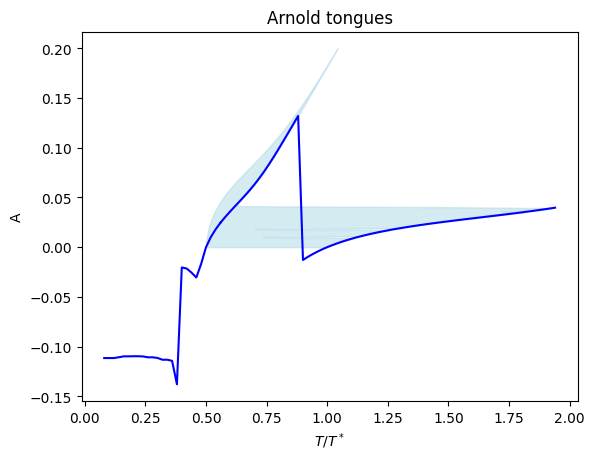

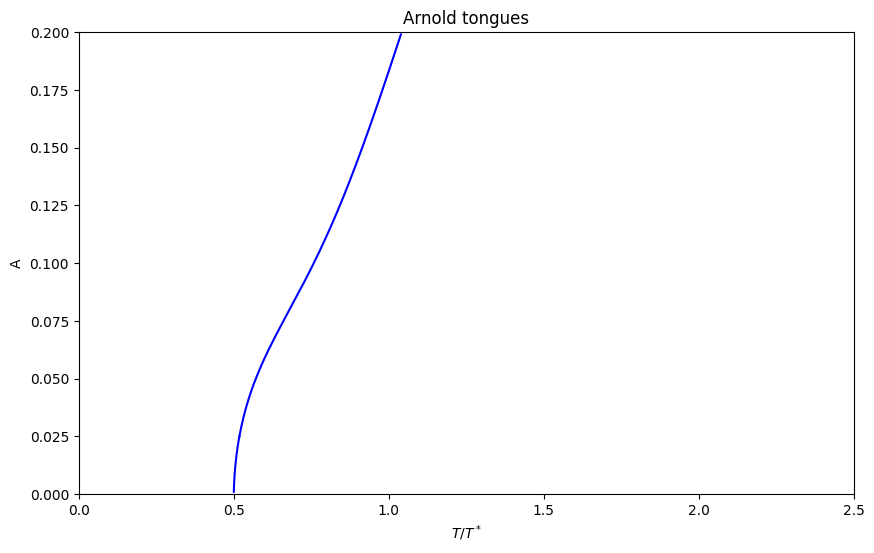

In [68]:
#COMPUTATION OF THE 1:2 ARNOLD TONGUE
# Set the step increment h
h = 0.001  # The desired step size
num_iterations_up_r = 25  # Number of iterations you want

# Initialize lists to store results
T_values_right_1 = []
A_values_right_1 = []

# Initialize T to 95% of Period
A = 0.025

# Initial conditions
initial_guess = [17.74, 0.52*Period]

# Function to find roots
def phase_conditions_root_squared(vars):
    theta, T = vars  # Unpack variables

    # Evaluate the stroboscopic map
    Phi_T = stroboscopic_map_squared(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    # Derivative with respect to theta
    dPhi_dtheta = derivative_stroboscopic_map_squared(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])

# Loop to iterate and find new points
for i in range(num_iterations_up_r):
    # Use fsolve to find a root
    solution = root(phase_conditions_root_squared, initial_guess, method='hybr', tol=1e-8)

    # Extract results
    theta_solution, T_solution = solution.x

    # Store the results in the lists
    T_values_right_1.append(T_solution / Period)  # Store normalized T
    A_values_right_1.append(A)    # Store A

    print(A)
    # Prepare the new T
    A -= 0.001  # Decrease T
    initial_guess = [theta_solution, T_solution]  # Use the found solution as the new initial point

num_iterations_down_r = 175
A = 0.025

# Initial conditions
initial_guess = [17.74, 0.52*Period]

# Loop to iterate and find new points
for i in range(num_iterations_down_r):
    # Use fsolve to find a root
    solution = root(phase_conditions_root_squared, initial_guess, method='hybr', tol=1e-8)

    # Extract results
    theta_solution, T_solution = solution.x

    # Store the results in the lists
    T_values_right_1.append(T_solution / Period)  # Store normalized T
    A_values_right_1.append(A)    # Store A

    print(A)
    # Prepare the new T
    A += 0.001  # Decrease T
    initial_guess = [theta_solution, T_solution]  # Use the found solution as the new initial point


# Create a common set of points for the y-axis (A), e.g., from 0 to 0.2
A_common = np.linspace(0, 0.2, 200)

interp_right = interp1d(A_values_right_1, T_values_right_1, bounds_error=False, fill_value="extrapolate")

T_values_right_interp_1_I = interp_right(A_common)


# Function to find roots
def phase_conditions_root_squared_A(vars):
    theta, A = vars  # Unpack variables

    # Evaluate the stroboscopic map
    Phi_T = stroboscopic_map_squared(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    # Derivative with respect to theta
    dPhi_dtheta = derivative_stroboscopic_map_squared(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])


# Set the step increment h
h = 0.02  # The desired step size
num_iterations_up_left = 70  # Number of iterations you want

# Initialize lists to store results
T_values_1_I = []
A_values_1_I = []

T = 0.56 * Period
# Initial conditions
initial_guess = [10.317, 0.025]

# Loop to iterate and find new points
for i in range(num_iterations_up_left):
    # Use fsolve to find a root
    solution = root(phase_conditions_root_squared_A, initial_guess, method='hybr', tol=1e-8)

    # Extract results
    theta_solution, A_solution = solution.x

    # Store the results in the lists
    T_values_1_I.append(T / Period)  # Store normalized T
    A_values_1_I.append(A_solution)    # Store A

    print(T / Period)
    # Prepare the new T
    T += h * Period  # Increase T
    initial_guess = [theta_solution, A_solution]  # Use the found solution as the new initial point

num_iterations_down_left = 15
T = 0.56 * Period
# Initial conditions
initial_guess = [10.317, 0.025]

# Loop to iterate and find new points
for i in range(num_iterations_down_left):
    # Use fsolve to find a root
    solution = root(phase_conditions_root_squared_A, initial_guess, method='hybr', tol=1e-8)

    # Extract results
    theta_solution, A_solution = solution.x

    # Store the results in the lists
    T_values_1_I.append(T / Period)  # Store normalized T
    A_values_1_I.append(A_solution)    # Store A

    print(T / Period)
    # Prepare the new T
    T -= h * Period  # Decrease T
    initial_guess = [theta_solution, A_solution]  # Use the found solution as the new initial point


# Create a common set of points for the y-axis (A), e.g., from 0 to 0.2
A_common = np.linspace(0, 0.2, 200)

# Interpolate both curves for these common points based on A
interp_left = interp1d(A_values_1_I, T_values_1_I, bounds_error=False, fill_value="extrapolate")

# Evaluate both interpolations at the common A points
T_values_left_interp_1_I = interp_left(A_common)


plt.plot(T_values_1_I[0:num_iterations_up_left], A_values_1_I[0:num_iterations_up_left], color='blue')
plt.plot(T_values_1_I[num_iterations_up_left:], A_values_1_I[num_iterations_up_left:], color='blue')

# Fill the area between the two interpolated curves
plt.fill_betweenx(A_common, T_values_left_interp_1_I, T_values_right_interp_1_I, color='lightblue', alpha=0.5)


# Labels and additional settings
plt.xlabel(r'$T/T^*$')
plt.ylabel('A')
plt.title('Arnold tongues')
plt.grid(False)
plt.show()


# Saving data to .npy files
np.save("A_common.npy", A_common)
np.save("T_values_left_interp_1_I.npy", T_values_left_interp_1_I)


# Plot the original curves
plt.figure(figsize=(10, 6))
plt.xlim(0, 2.5)
plt.ylim(0, 0.2)
plt.plot(T_values_right_1[0:num_iterations_up_r], A_values_right_1[0:num_iterations_up_r], color='blue')
plt.plot(T_values_right_1[num_iterations_up_r:], A_values_right_1[num_iterations_up_r:], color='blue')


# Labels and additional settings
plt.xlabel(r'$T/T^*$')
plt.ylabel('A')
plt.title('Arnold tongues')
plt.grid(False)
plt.show()


np.save("T_values_right_interp_1_I.npy", T_values_right_interp_1_I)


0.025
0.024
0.023
0.022
0.020999999999999998
0.019999999999999997
0.018999999999999996
0.017999999999999995
0.016999999999999994
0.015999999999999993
0.014999999999999993
0.013999999999999992
0.01299999999999999
0.01199999999999999
0.010999999999999989
0.009999999999999988
0.008999999999999987
0.007999999999999986
0.006999999999999986
0.005999999999999986
0.004999999999999986
0.003999999999999986
0.002999999999999986
0.001999999999999986
0.0009999999999999861
0.025
0.026000000000000002
0.027000000000000003
0.028000000000000004
0.029000000000000005
0.030000000000000006
0.031000000000000007
0.03200000000000001
0.03300000000000001
0.03400000000000001
0.03500000000000001
0.03600000000000001
0.03700000000000001
0.03800000000000001
0.039000000000000014
0.040000000000000015
0.041000000000000016
0.042000000000000016
0.04300000000000002
0.04400000000000002
0.04500000000000002
0.04600000000000002
0.04700000000000002
0.04800000000000002
0.04900000000000002
0.050000000000000024
0.05100000000000002

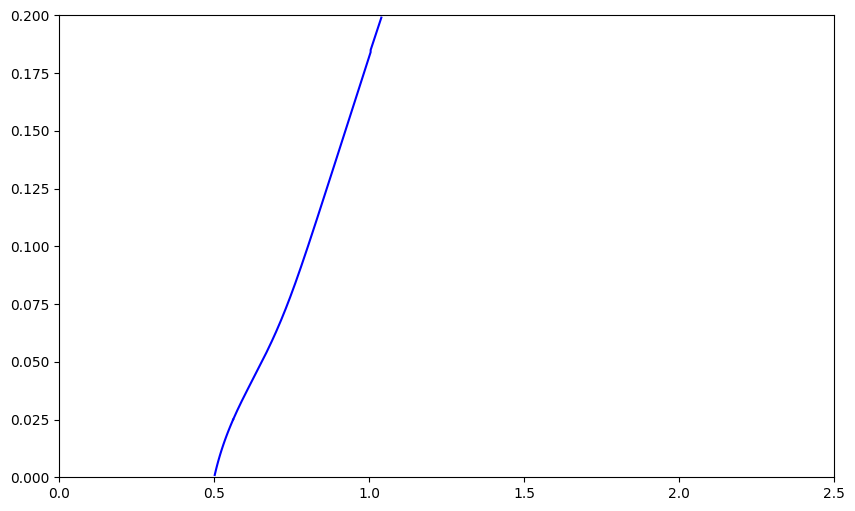

In [85]:
# Set the step increment h
h = 0.001  # The desired step size
num_iterations_up_r = 25  # Number of iterations you want

# Initialize lists to store results
T_values_right_1_p = []
A_values_right_1_p = []

# Initialize T to 95% of Period
A = 0.025

# Initial conditions
initial_guess = [10.317, 0.56*Period]

# Function to find roots
def phase_conditions_root_squared(vars):
    theta, T = vars  # Unpack variables

    # Evaluate the stroboscopic map
    Phi_T = stroboscopic_map_squared(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    # Derivative with respect to theta
    dPhi_dtheta = derivative_stroboscopic_map_squared(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])

# Loop to iterate and find new points
for i in range(num_iterations_up_r):
    # Use fsolve to find a root
    solution = root(phase_conditions_root_squared, initial_guess, method='hybr', tol=1e-8)

    # Extract results
    theta_solution, T_solution = solution.x

    # Store the results in the lists
    T_values_right_1_p.append(T_solution / Period)  # Store normalized T
    A_values_right_1_p.append(A)    # Store A

    print(A)
    # Prepare the new T
    A -= 0.001  # Decrease T
    initial_guess = [theta_solution, T_solution]  # Use the found solution as the new initial point

num_iterations_down_r = 175
A = 0.025

# Initial conditions
initial_guess = [10.317, 0.56*Period]

# Loop to iterate and find new points
for i in range(num_iterations_down_r):
    # Use fsolve to find a root
    solution = root(phase_conditions_root_squared, initial_guess, method='hybr', tol=1e-8)

    # Extract results
    theta_solution, T_solution = solution.x

    # Store the results in the lists
    T_values_right_1_p.append(T_solution / Period)  # Store normalized T
    A_values_right_1_p.append(A)    # Store A

    print(A)
    # Prepare the new T
    A += 0.001  # Increase T
    initial_guess = [theta_solution, T_solution]  # Use the found solution as the new initial point


# Plot the original curves
plt.figure(figsize=(10, 6))
plt.xlim(0, 2.5)
plt.ylim(0, 0.2)
plt.plot(T_values_right_1_p[0:num_iterations_up_r], A_values_right_1_p[0:num_iterations_up_r], color='blue')
plt.plot(T_values_right_1_p[num_iterations_up_r:], A_values_right_1_p[num_iterations_up_r:], color='blue')


In [87]:
interp_left = interp1d(A_values_right_1_p, T_values_right_1_p, bounds_error=False, fill_value="extrapolate")

# Evaluar ambas interpolaciones en los puntos comunes de A
T_values_left_interp_1_I = interp_left(A_common)

# Saving data to .npy files
np.save("A_common.npy", A_common)
np.save("T_values_left_interp_1_I.npy", T_values_left_interp_1_I)

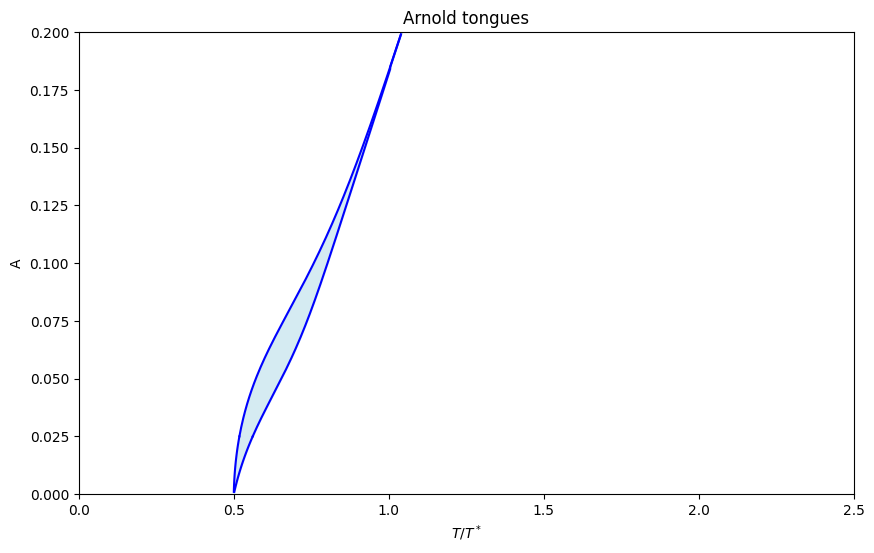

In [88]:
plt.figure(figsize=(10, 6))
plt.xlim(0, 2.5)
plt.ylim(0, 0.2)
plt.plot(T_values_right_1[0:num_iterations_up_r], A_values_right_1[0:num_iterations_up_r], color='blue')
plt.plot(T_values_right_1[num_iterations_up_r:], A_values_right_1[num_iterations_up_r:],color='blue')
plt.plot(T_values_right_1_p[0:num_iterations_up_r], A_values_right_1_p[0:num_iterations_up_r], color='blue')
plt.plot(T_values_right_1_p[num_iterations_up_r:], A_values_right_1_p[num_iterations_up_r:],color='blue')

plt.fill_betweenx(A_common, T_values_left_interp_1_I, T_values_right_interp_1_I, color='lightblue', alpha=0.5)

plt.xlabel(r'$T/T^*$')
plt.ylabel('A')
plt.title('Arnold tongues')
plt.grid(False)
plt.show()

10.021063374332337
-13.951175548783475


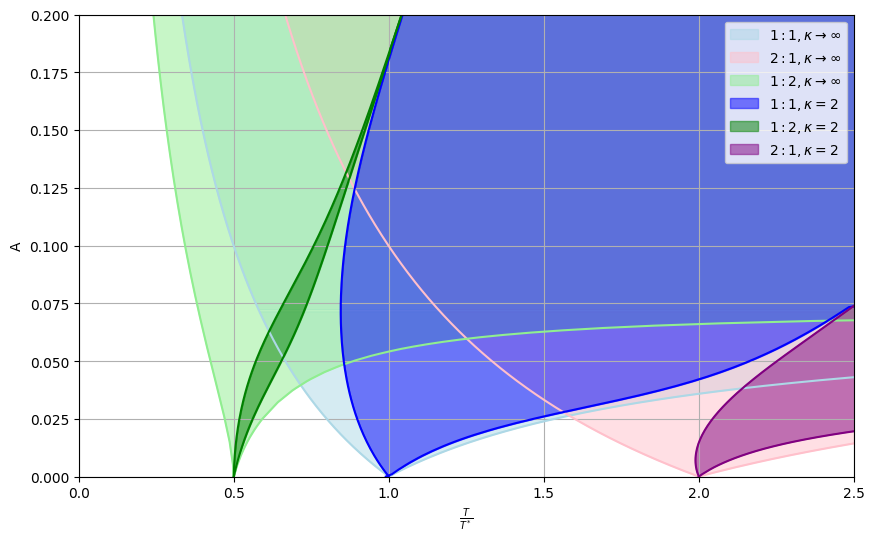

In [44]:
#FINALS ARNOLD TONGUES: k=2, k=infinity
import numpy as np

# Loading data back
A_common = np.load("A_common.npy")
T_values_left_interp_I = np.load("T_values_left_interp_I.npy")
T_values_right_interp_I = np.load("T_values_right_interp_I.npy")
T_values_left_interp_1_I = np.load("T_values_left_interp_1_I.npy")
T_values_right_interp_1_I = np.load("T_values_right_interp_1_I.npy")
T_values_left_interp_2_I = np.load("T_values_left_interp_2_I.npy")
T_values_right_interp_2_I = np.load("T_values_right_interp_2_I.npy")
T_left = np.load("T_values_left_interp_eii_1_2_inf.npy")
T_right = np.load("T_values_right_interp_eii_1_2_inf.npy")




time_points = np.linspace(0, Period, 1000)  # Sample points across one period
interp_values = interp_orbit_iPRC(time_points)  # Evaluate interp_orbit_iPRC over these points

# Extract components 1 and 5, and calculate their sum
Z_values = interp_values[1] + interp_values[5]  # Sum of component 1 and component 5

# Calculate Zmax and Zmin
Zmax = np.max(Z_values)
Zmin = np.min(Z_values)
print(Zmax)
print(Zmin)

# Define the range for A and calculate corresponding T/T* values
A_values = np.linspace(0, 0.2, 500)
T_over_Tstar_max = 1 + A_values * Zmax
T_over_Tstar_min = 1 + A_values * Zmin

T_over_Tstar_max_2 = (1/2)*(1 + A_values * Zmax)
T_over_Tstar_min_2 = (1/2)*(1 + A_values * Zmin)


T_over_Tstar_max = T_over_Tstar_max[T_over_Tstar_max > 0]
T_over_Tstar_min = T_over_Tstar_min[T_over_Tstar_min > 0]

T_over_Tstar_max_2 = T_over_Tstar_max_2[T_over_Tstar_max_2 > 0]
T_over_Tstar_min_2 = T_over_Tstar_min_2[T_over_Tstar_min_2 > 0]


# Plotting
plt.figure(figsize=(10, 6))
fill = np.full(len(A_values), 10)




plt.fill_betweenx(A_values[:len(T_over_Tstar_min)], 1 / T_over_Tstar_min[:len(T_over_Tstar_min)], 1 / T_over_Tstar_max[:len(T_over_Tstar_min)], color='lightblue', alpha=0.5,label=r'$1:1, \kappa \rightarrow \infty$')
plt.fill_betweenx(A_values[len(T_over_Tstar_min)+1:], 1 / T_over_Tstar_max[len(T_over_Tstar_min)+1:],fill[len(T_over_Tstar_min)+1:], color='lightblue', alpha=0.5)
# Plot the boundary lines for the filled region
plt.plot(1/T_over_Tstar_max, A_values[:len(T_over_Tstar_max)], color='lightblue')
plt.plot(1/T_over_Tstar_min, A_values[:len(T_over_Tstar_min)], color='lightblue')


plt.fill_betweenx(A_values[:len(T_over_Tstar_min_2)], 1 / T_over_Tstar_min_2[:len(T_over_Tstar_min_2)], 1 / T_over_Tstar_max_2[:len(T_over_Tstar_min_2)], color='pink', alpha=0.5,label=r'$2:1, \kappa \rightarrow \infty$')
plt.fill_betweenx(A_values[len(T_over_Tstar_min_2)+1:], 1 / T_over_Tstar_max_2[len(T_over_Tstar_min_2)+1:],fill[len(T_over_Tstar_min_2)+1:], color='pink', alpha=0.5)


# Plot the boundary lines for the filled region
plt.plot(1/T_over_Tstar_max_2, A_values[:len(T_over_Tstar_max_2)], color='pink')
plt.plot(1/T_over_Tstar_min_2, A_values[:len(T_over_Tstar_min_2)], color='pink')

plt.fill_betweenx(A_common, T_left, T_right, color='lightgreen', alpha=0.5,label=r'$1:2, \kappa \rightarrow \infty$')
plt.plot(T_left, A_common, color='lightgreen')
plt.plot(T_right, A_common, color='lightgreen')
# Gráfico de Arnold tongues y relleno entre curvas interpoladas 1:1
plt.plot(T_values_left_interp_I, A_common, color='blue')
plt.plot(T_values_right_interp_I, A_common, color='blue')
plt.fill_betweenx(A_common, T_values_left_interp_I, T_values_right_interp_I, color='blue',alpha=0.5,label=r'$1:1, \kappa=2$')



#Plot 1:2

plt.plot(T_values_left_interp_1_I, A_common, color='green')
plt.plot(T_values_right_interp_1_I, A_common, color='green')
plt.fill_betweenx(A_common, T_values_left_interp_1_I, T_values_right_interp_1_I, color='green',alpha=0.5,label=r'$1:2, \kappa=2$')


#Plot 2:1

plt.plot(T_values_left_interp_2_I, A_common, color='purple')
plt.plot(T_values_right_interp_2_I, A_common, color='purple')
plt.fill_betweenx(A_common, T_values_left_interp_2_I, T_values_right_interp_2_I, color='purple',alpha=0.5,label=r'$2:1, \kappa=2$')



# Setting limits for the axes
plt.xlim(0, 2.5)
plt.ylim(0, 0.2)

# Labels and title
plt.xlabel(r'$\frac{T}{T^*}$')
plt.ylabel("A")

plt.grid(True)
plt.legend(loc='best')
plt.show()



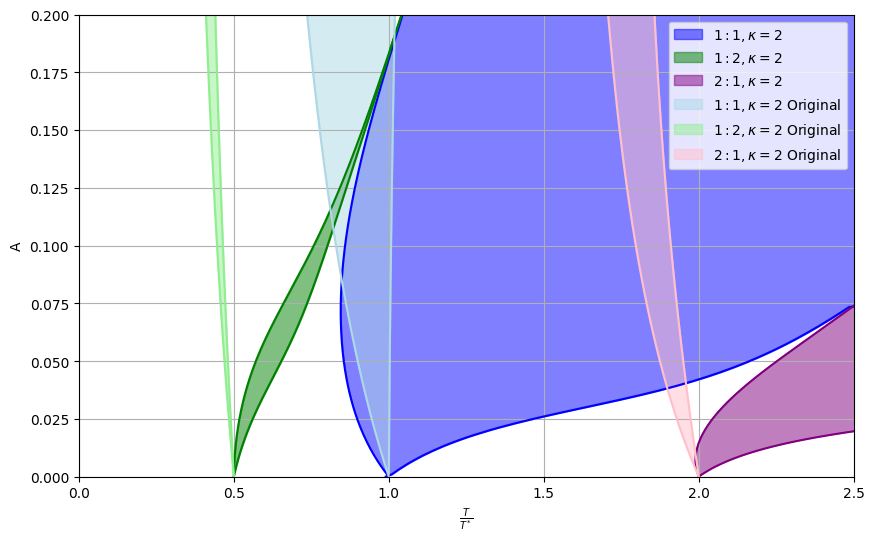

In [39]:
#Comparison between the obtained Arnold tongues and the original ones for k=2

import numpy as np

# Loading data back
A_common = np.load("A_common.npy")
T_values_left_interp_I = np.load("T_values_left_interp_I.npy")
T_values_right_interp_I = np.load("T_values_right_interp_I.npy")
T_values_left_interp_1_I = np.load("T_values_left_interp_1_I.npy")
T_values_right_interp_1_I = np.load("T_values_right_interp_1_I.npy")
T_values_left_interp_2_I = np.load("T_values_left_interp_2_I.npy")
T_values_right_interp_2_I = np.load("T_values_right_interp_2_I.npy")

T_values_left_interp = np.load("T_values_left_interp.npy")
T_values_right_interp = np.load("T_values_right_interp.npy")
T_values_left_interp_1 = np.load("T_values_left_interp_1.npy")
T_values_right_interp_1 = np.load("T_values_right_interp_1.npy")
T_values_left_interp_2 = np.load("T_values_left_interp_2.npy")
T_values_right_interp_2 = np.load("T_values_right_interp_2.npy")




plt.figure(figsize=(10, 6))


plt.plot(T_values_left_interp_I, A_common, color='blue')
plt.plot(T_values_right_interp_I, A_common, color='blue')
plt.fill_betweenx(A_common, T_values_left_interp_I, T_values_right_interp_I, color='blue',alpha=0.5,label=r'$1:1, \kappa=2$')



#Plot 1:2

plt.plot(T_values_left_interp_1_I, A_common, color='green')
plt.plot(T_values_right_interp_1_I, A_common, color='green')
plt.fill_betweenx(A_common, T_values_left_interp_1_I, T_values_right_interp_1_I, color='green',alpha=0.5,label=r'$1:2, \kappa=2$')


#Plot 2:1

plt.plot(T_values_left_interp_2_I, A_common, color='purple')
plt.plot(T_values_right_interp_2_I, A_common, color='purple')
plt.fill_betweenx(A_common, T_values_left_interp_2_I, T_values_right_interp_2_I, color='purple',alpha=0.5,label=r'$2:1, \kappa=2$')


plt.plot(T_values_left_interp, A_common, color='lightblue')
plt.plot(T_values_right_interp[1:], A_common[1:], color='lightblue')
plt.fill_betweenx(A_common[1:], T_values_left_interp[1:], T_values_right_interp[1:], color='lightblue',alpha=0.5,label=r'$1:1, \kappa=2$ Original')



#Plot 1:2

plt.plot(T_values_left_interp_1, A_common, color='lightgreen')
plt.plot(T_values_right_interp_1, A_common, color='lightgreen')
plt.fill_betweenx(A_common, T_values_left_interp_1, T_values_right_interp_1, color='lightgreen',alpha=0.5,label=r'$1:2, \kappa=2$ Original')


#Plot 2:1

plt.plot(T_values_left_interp_2, A_common, color='pink')
plt.plot(T_values_right_interp_2, A_common, color='pink')
plt.fill_betweenx(A_common, T_values_left_interp_2, T_values_right_interp_2, color='pink',alpha=0.5,label=r'$2:1, \kappa=2$ Original')



# Setting limits for the axes
plt.xlim(0, 2.5)
plt.ylim(0, 0.2)

# Labels and title
plt.xlabel(r'$\frac{T}{T^*}$')
plt.ylabel("A")

plt.grid(True)
plt.legend(loc='best')
plt.show()

### CTC measures

In [ ]:
#Pre computations of Delta tau
T=1.75*Period
A=0.07
t= np.linspace(0, 80 * T, 1000000) 
sol = odeint(neural_network_I, P_1, t, args =(A,T,), atol=atol, rtol=rtol)
P_2=sol[-1]
t= np.linspace(0, 2*T, 1000000)
sol=odeint(neural_network_I, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        
# Extract r_i(t) = x[5] and p(t)
r_i = sol[:, 4]
p_t = p(t, T)
        
# Ignore the initial transient by selecting only the times after transient_time
t_after_transient = t[(t <= T)]
#r_i_after_transient = r_i[t >= transient_time]
p_after_transient = p_t[(t <= T)]
        
# Find the time t_p of the maximum of p after the transient
t_p_index = np.argmax(p_after_transient)  # Index of max p after transient
t_p = t_after_transient[t_p_index]        # Time at which p reaches maximum
        
        
# Limit search for r_i to one period T after t_p
t_within_one_period = t[(t>=t_p)&(t<t_p+T)]
r_i_within_one_period = r_i[(t>=t_p)&(t<t_p+T)]
        
# Find the maximum of r_i within this period
t_inh_index = np.argmax(r_i_within_one_period)  # Index of max r_i within one period after t_p
t_inh = t_within_one_period[t_inh_index] 

print((t_inh - t_p) / T)
indices_after_4T = ((t >= t_p-7050)&(t<=t_p+7050))
# Optional: Plotting r_i and p to visualize
plt.figure(figsize=(12, 6))
plt.plot(t[indices_after_4T], r_i[indices_after_4T], label=r'$r_i(t)$ (inhibitory rate)')
plt.plot(t[indices_after_4T], A*p_t[indices_after_4T], label=r'$p(t)$ (external input)', linestyle='--')
plt.axvline(t_inh, color='red', linestyle=':', label=r'$t_{\text{inh}}$ (max $r_i$ after transient)')
plt.axvline(t_p, color='blue', linestyle=':', label=r'$t_p$ (max $p$ after transient)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Inhibitory Neuron Activity $r_i(t)$ and External Input $p(t)$ after Transient')
plt.legend()
plt.show()

In [ ]:
#Computation of Delta tau
#We just save and plot the values of A and T, such that Delta tau is consistent through 5 consecutive periods

from scipy.interpolate import interp1d
t = np.linspace(0, 30 * Period, 100000)  # Adjust time range and resolution as needed
A_values= np.linspace(0.01,0.2,20)
# Prepare plot
# Initialize a list to store T_ratio_values for each A
T_ratio_matrix = []
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1,len(A_values)))

# Loop over each A
for i, A in enumerate(A_values):
    print(A)
    # Interpolate bounds for T based on A
    if A<0.075:
        T_left = interp_right(A)*Period
        T_right = interp_left(A)*Period
    else:
        T_left = interp_right(A)*Period
        T_right = 2.5*Period
    # Generate equidistant values of T within bounds
    T_values = np.linspace(T_left+0.003*Period, T_right-0.003*Period, 120)
    
    
    # Store Delta_tau values for current A
    delta_tau_values = []
    T_ratio_values = []
    # Listas para almacenar los grupos separados
    T_ratio_plus = []     # Para T_ratio con delta_tau > 0.6
    Delta_tau_plus = []   # Para delta_tau > 0.6
    T_ratio_minus = []    # Para T_ratio con delta_tau <= 0.6
    Delta_tau_minus = []  # Para delta_tau <= 0.6

    for T in T_values:
        # Simulate the system with current A and T
        t= np.linspace(0, 80 * T, 1000000) 
        sol = odeint(neural_network_I, P_1, t, args =(A,T,), atol=atol, rtol=rtol)
        P_2=sol[-1]
        t= np.linspace(0, 2*T, 1000000)
        sol=odeint(neural_network_I, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        
        # Extract r_i(t) = x[5] and p(t)
        r_i = sol[:, 4]
        p_t = p(t, T)
        
        # Ignore the initial transient by selecting only the times after transient_time
        t_after_transient = t[(t <= T)]
        #r_i_after_transient = r_i[t >= transient_time]
        p_after_transient = p_t[(t <= T)]
        
        # Find the time t_p of the maximum of p after the transient
        t_p_index = np.argmax(p_after_transient)  # Index of max p after transient
        t_p = t_after_transient[t_p_index]        # Time at which p reaches maximum
        
        
        # Limit search for r_i to one period T after t_p
        t_within_one_period = t[(t>=t_p)&(t<t_p+T)]
        r_i_within_one_period = r_i[(t>=t_p)&(t<t_p+T)]
        
        # Find the maximum of r_i within this period
        t_inh_index = np.argmax(r_i_within_one_period)  # Index of max r_i within one period after t_p
        t_inh = t_within_one_period[t_inh_index]        # Time at which r_i reaches max within one period after t_p
        
        # Calculate Delta_tau
        Delta_tau_1 = (t_inh - t_p) / T
        
        t_val= np.linspace(0, T, 1000000) 
        sol = odeint(neural_network_I, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        P_3=sol[-1]
        t= np.linspace(0, 2*T, 1000000)
        sol=odeint(neural_network_I, P_3, t, args =(A,T,), atol=atol, rtol=rtol)
        
        # Extract r_i(t) = x[5] and p(t)
        r_i = sol[:, 4]
        p_t = p(t, T)
        
        # Ignore the initial transient by selecting only the times after transient_time
        t_after_transient = t[(t <= T)]
        #r_i_after_transient = r_i[t >= transient_time]
        p_after_transient = p_t[(t <= T)]
        
        # Find the time t_p of the maximum of p after the transient
        t_p_index = np.argmax(p_after_transient)  # Index of max p after transient
        t_p = t_after_transient[t_p_index]        # Time at which p reaches maximum
        
        
        # Limit search for r_i to one period T after t_p
        t_within_one_period = t[(t>=t_p)&(t<t_p+T)]
        r_i_within_one_period = r_i[(t>=t_p)&(t<t_p+T)]
        
        # Find the maximum of r_i within this period
        t_inh_index = np.argmax(r_i_within_one_period)  # Index of max r_i within one period after t_p
        t_inh = t_within_one_period[t_inh_index]        # Time at which r_i reaches max within one period after t_p
        
        # Calculate Delta_tau
        Delta_tau_2 = (t_inh - t_p) / T
        
        t_val= np.linspace(0, 2*T, 1000000) 
        sol = odeint(neural_network_I, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        P_4=sol[-1]
        t= np.linspace(0, 2*T, 1000000)
        sol=odeint(neural_network_I, P_4, t, args =(A,T,), atol=atol, rtol=rtol)
        
        # Extract r_i(t) = x[5] and p(t)
        r_i = sol[:, 4]
        p_t = p(t, T)
        
        # Ignore the initial transient by selecting only the times after transient_time
        t_after_transient = t[(t <= T)]
        #r_i_after_transient = r_i[t >= transient_time]
        p_after_transient = p_t[(t <= T)]
        
        # Find the time t_p of the maximum of p after the transient
        t_p_index = np.argmax(p_after_transient)  # Index of max p after transient
        t_p = t_after_transient[t_p_index]        # Time at which p reaches maximum
        
        
        # Limit search for r_i to one period T after t_p
        t_within_one_period = t[(t>=t_p)&(t<t_p+T)]
        r_i_within_one_period = r_i[(t>=t_p)&(t<t_p+T)]
        
        # Find the maximum of r_i within this period
        t_inh_index = np.argmax(r_i_within_one_period)  # Index of max r_i within one period after t_p
        t_inh = t_within_one_period[t_inh_index]        # Time at which r_i reaches max within one period after t_p
        
        # Calculate Delta_tau
        Delta_tau_3 = (t_inh - t_p) / T
        
        t_val= np.linspace(0, 3*T, 1000000) 
        sol = odeint(neural_network_I, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        P_4=sol[-1]
        t= np.linspace(0, 2*T, 1000000)
        sol=odeint(neural_network_I, P_4, t, args =(A,T,), atol=atol, rtol=rtol)
        
        # Extract r_i(t) = x[5] and p(t)
        r_i = sol[:, 4]
        p_t = p(t, T)
        
        # Ignore the initial transient by selecting only the times after transient_time
        t_after_transient = t[(t <= T)]
        #r_i_after_transient = r_i[t >= transient_time]
        p_after_transient = p_t[(t <= T)]
        
        # Find the time t_p of the maximum of p after the transient
        t_p_index = np.argmax(p_after_transient)  # Index of max p after transient
        t_p = t_after_transient[t_p_index]        # Time at which p reaches maximum
        
        
        # Limit search for r_i to one period T after t_p
        t_within_one_period = t[(t>=t_p)&(t<t_p+T)]
        r_i_within_one_period = r_i[(t>=t_p)&(t<t_p+T)]
        
        # Find the maximum of r_i within this period
        t_inh_index = np.argmax(r_i_within_one_period)  # Index of max r_i within one period after t_p
        t_inh = t_within_one_period[t_inh_index]        # Time at which r_i reaches max within one period after t_p
        
        # Calculate Delta_tau
        Delta_tau_3 = (t_inh - t_p) / T
        
        t_val= np.linspace(0, 3*T, 1000000) 
        sol = odeint(neural_network_I, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        P_5=sol[-1]
        t= np.linspace(0, 2*T, 1000000)
        sol=odeint(neural_network_I, P_5, t, args =(A,T,), atol=atol, rtol=rtol)
        
        # Extract r_i(t) = x[5] and p(t)
        r_i = sol[:, 4]
        p_t = p(t, T)
        
        # Ignore the initial transient by selecting only the times after transient_time
        t_after_transient = t[(t <= T)]
        #r_i_after_transient = r_i[t >= transient_time]
        p_after_transient = p_t[(t <= T)]
        
        # Find the time t_p of the maximum of p after the transient
        t_p_index = np.argmax(p_after_transient)  # Index of max p after transient
        t_p = t_after_transient[t_p_index]        # Time at which p reaches maximum
        
        
        # Limit search for r_i to one period T after t_p
        t_within_one_period = t[(t>=t_p)&(t<t_p+T)]
        r_i_within_one_period = r_i[(t>=t_p)&(t<t_p+T)]
        
        # Find the maximum of r_i within this period
        t_inh_index = np.argmax(r_i_within_one_period)  # Index of max r_i within one period after t_p
        t_inh = t_within_one_period[t_inh_index]        # Time at which r_i reaches max within one period after t_p
        
        # Calculate Delta_tau
        Delta_tau_4 = (t_inh - t_p) / T
        
        
        t_val= np.linspace(0, 4*T, 1000000) 
        sol = odeint(neural_network_I, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        P_6=sol[-1]
        t= np.linspace(0, 2*T, 1000000)
        sol=odeint(neural_network_I, P_6, t, args =(A,T,), atol=atol, rtol=rtol)
        
        # Extract r_i(t) = x[5] and p(t)
        r_i = sol[:, 4]
        p_t = p(t, T)
        
        # Ignore the initial transient by selecting only the times after transient_time
        t_after_transient = t[(t <= T)]
        #r_i_after_transient = r_i[t >= transient_time]
        p_after_transient = p_t[(t <= T)]
        
        # Find the time t_p of the maximum of p after the transient
        t_p_index = np.argmax(p_after_transient)  # Index of max p after transient
        t_p = t_after_transient[t_p_index]        # Time at which p reaches maximum
        
        
        # Limit search for r_i to one period T after t_p
        t_within_one_period = t[(t>=t_p)&(t<t_p+T)]
        r_i_within_one_period = r_i[(t>=t_p)&(t<t_p+T)]
        
        # Find the maximum of r_i within this period
        t_inh_index = np.argmax(r_i_within_one_period)  # Index of max r_i within one period after t_p
        t_inh = t_within_one_period[t_inh_index]        # Time at which r_i reaches max within one period after t_p
        
        # Calculate Delta_tau
        Delta_tau_5 = (t_inh - t_p) / T
        
        if ((abs(Delta_tau_1-Delta_tau_2)<0.01)&(abs(Delta_tau_1-Delta_tau_3)<0.01)&(abs(Delta_tau_1-Delta_tau_4)<0.01)&(abs(Delta_tau_1-Delta_tau_5)<0.01)):
            Delta_tau = (Delta_tau_1+Delta_tau_2+Delta_tau_3+Delta_tau_4+Delta_tau_5)/5
            T_ratio = T / Period
        
            # Store values for plotting
            delta_tau_values.append(Delta_tau)
            T_ratio_values.append(T_ratio)
        
        else: print(f'Not satisfied for T={T/Period}')
   
    for delta_tau, T_ratio in zip(delta_tau_values, T_ratio_values):
        if delta_tau > 0.6:
            Delta_tau_plus.append(delta_tau)
            T_ratio_plus.append(T_ratio)
        else:
            Delta_tau_minus.append(delta_tau)
            T_ratio_minus.append(T_ratio)

    T_ratio_matrix.append(T_ratio_values)
    # Plot Delta_tau vs T / Period for the current A
    plt.scatter(T_ratio_plus, Delta_tau_plus, label=f'A={A:.2f}', color=colors[i],s=1)
    plt.scatter(T_ratio_minus, Delta_tau_minus, color=colors[i],s=1)
    
# Label and show plot
plt.xlabel(r'$T / T^*$')
plt.ylabel(r'$\Delta_{\tau}$')
plt.legend(loc='upper left')
plt.title(r'$\Delta_{\tau}$ vs $T / T^*$ for Different Values of A')
plt.grid(True)
plt.show()

In [ ]:
from scipy.interpolate import interp1d
t = np.linspace(0, 30 * Period, 100000)  # Adjust time range and resolution as needed
A_values= np.linspace(0.01,0.1,10)
# Prepare plot
# Initialize a list to store T_ratio_values for each A
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1,len(A_values)))

# Loop over each A
for i, A in enumerate(A_values):
    print(A)
    T_values = filtered_T_ratio_matrix[i]
    
    
    # Store Delta_tau values for current A
    delta_tau_values = []
    T_ratio_values = []
    # Listas para almacenar los grupos separados
    T_ratio_plus = []     # Para T_ratio con delta_tau > 0.6
    Delta_tau_plus = []   # Para delta_tau > 0.6
    T_ratio_minus = []    # Para T_ratio con delta_tau <= 0.6
    Delta_tau_minus = []  # Para delta_tau <= 0.6

    for T in T_values:
        T=Period*T
        print(T)
        # Simulate the system with current A and T
        t= np.linspace(0, 80 * T, 1000000) 
        sol = odeint(neural_network_I, P_1, t, args =(A,T,), atol=atol, rtol=rtol)
        P_2=sol[-1]
        t= np.linspace(0, 2*T, 1000000)
        sol=odeint(neural_network_I, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        
        # Extract r_i(t) = x[5] and p(t)
        r_i = sol[:, 4]
        p_t = p(t, T)
        
        # Ignore the initial transient by selecting only the times after transient_time
        t_after_transient = t[(t <= T)]
        #r_i_after_transient = r_i[t >= transient_time]
        p_after_transient = p_t[(t <= T)]
        
        # Find the time t_p of the maximum of p after the transient
        t_p_index = np.argmax(p_after_transient)  # Index of max p after transient
        t_p = t_after_transient[t_p_index]        # Time at which p reaches maximum
        
        
        # Limit search for r_i to one period T after t_p
        t_within_one_period = t[(t>=t_p)&(t<t_p+T)]
        r_i_within_one_period = r_i[(t>=t_p)&(t<t_p+T)]
        
        # Find the maximum of r_i within this period
        t_inh_index = np.argmax(r_i_within_one_period)  # Index of max r_i within one period after t_p
        t_inh = t_within_one_period[t_inh_index]        # Time at which r_i reaches max within one period after t_p
        
        # Calculate Delta_tau
        Delta_tau_1 = (t_inh - t_p) / T
        
        t_val= np.linspace(0, T, 1000000) 
        sol = odeint(neural_network_I, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        P_3=sol[-1]
        t= np.linspace(0, 2*T, 1000000)
        sol=odeint(neural_network_I, P_3, t, args =(A,T,), atol=atol, rtol=rtol)
        
        # Extract r_i(t) = x[5] and p(t)
        r_i = sol[:, 4]
        p_t = p(t, T)
        
        # Ignore the initial transient by selecting only the times after transient_time
        t_after_transient = t[(t <= T)]
        #r_i_after_transient = r_i[t >= transient_time]
        p_after_transient = p_t[(t <= T)]
        
        # Find the time t_p of the maximum of p after the transient
        t_p_index = np.argmax(p_after_transient)  # Index of max p after transient
        t_p = t_after_transient[t_p_index]        # Time at which p reaches maximum
        
        
        # Limit search for r_i to one period T after t_p
        t_within_one_period = t[(t>=t_p)&(t<t_p+T)]
        r_i_within_one_period = r_i[(t>=t_p)&(t<t_p+T)]
        
        # Find the maximum of r_i within this period
        t_inh_index = np.argmax(r_i_within_one_period)  # Index of max r_i within one period after t_p
        t_inh = t_within_one_period[t_inh_index]        # Time at which r_i reaches max within one period after t_p
        
        # Calculate Delta_tau
        Delta_tau_2 = (t_inh - t_p) / T
        
        t_val= np.linspace(0, 2*T, 1000000) 
        sol = odeint(neural_network_I, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        P_4=sol[-1]
        t= np.linspace(0, 2*T, 1000000)
        sol=odeint(neural_network_I, P_4, t, args =(A,T,), atol=atol, rtol=rtol)
        
        # Extract r_i(t) = x[5] and p(t)
        r_i = sol[:, 4]
        p_t = p(t, T)
        
        # Ignore the initial transient by selecting only the times after transient_time
        t_after_transient = t[(t <= T)]
        #r_i_after_transient = r_i[t >= transient_time]
        p_after_transient = p_t[(t <= T)]
        
        # Find the time t_p of the maximum of p after the transient
        t_p_index = np.argmax(p_after_transient)  # Index of max p after transient
        t_p = t_after_transient[t_p_index]        # Time at which p reaches maximum
        
        
        # Limit search for r_i to one period T after t_p
        t_within_one_period = t[(t>=t_p)&(t<t_p+T)]
        r_i_within_one_period = r_i[(t>=t_p)&(t<t_p+T)]
        
        # Find the maximum of r_i within this period
        t_inh_index = np.argmax(r_i_within_one_period)  # Index of max r_i within one period after t_p
        t_inh = t_within_one_period[t_inh_index]        # Time at which r_i reaches max within one period after t_p
        
        # Calculate Delta_tau
        Delta_tau_3 = (t_inh - t_p) / T
        
        t_val= np.linspace(0, 3*T, 1000000) 
        sol = odeint(neural_network_I, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        P_4=sol[-1]
        t= np.linspace(0, 2*T, 1000000)
        sol=odeint(neural_network_I, P_4, t, args =(A,T,), atol=atol, rtol=rtol)
        
        # Extract r_i(t) = x[5] and p(t)
        r_i = sol[:, 4]
        p_t = p(t, T)
        
        # Ignore the initial transient by selecting only the times after transient_time
        t_after_transient = t[(t <= T)]
        #r_i_after_transient = r_i[t >= transient_time]
        p_after_transient = p_t[(t <= T)]
        
        # Find the time t_p of the maximum of p after the transient
        t_p_index = np.argmax(p_after_transient)  # Index of max p after transient
        t_p = t_after_transient[t_p_index]        # Time at which p reaches maximum
        
        
        # Limit search for r_i to one period T after t_p
        t_within_one_period = t[(t>=t_p)&(t<t_p+T)]
        r_i_within_one_period = r_i[(t>=t_p)&(t<t_p+T)]
        
        # Find the maximum of r_i within this period
        t_inh_index = np.argmax(r_i_within_one_period)  # Index of max r_i within one period after t_p
        t_inh = t_within_one_period[t_inh_index]        # Time at which r_i reaches max within one period after t_p
        
        # Calculate Delta_tau
        Delta_tau_3 = (t_inh - t_p) / T
        
        t_val= np.linspace(0, 3*T, 1000000) 
        sol = odeint(neural_network_I, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        P_5=sol[-1]
        t= np.linspace(0, 2*T, 1000000)
        sol=odeint(neural_network_I, P_5, t, args =(A,T,), atol=atol, rtol=rtol)
        
        # Extract r_i(t) = x[5] and p(t)
        r_i = sol[:, 4]
        p_t = p(t, T)
        
        # Ignore the initial transient by selecting only the times after transient_time
        t_after_transient = t[(t <= T)]
        #r_i_after_transient = r_i[t >= transient_time]
        p_after_transient = p_t[(t <= T)]
        
        # Find the time t_p of the maximum of p after the transient
        t_p_index = np.argmax(p_after_transient)  # Index of max p after transient
        t_p = t_after_transient[t_p_index]        # Time at which p reaches maximum
        
        
        # Limit search for r_i to one period T after t_p
        t_within_one_period = t[(t>=t_p)&(t<t_p+T)]
        r_i_within_one_period = r_i[(t>=t_p)&(t<t_p+T)]
        
        # Find the maximum of r_i within this period
        t_inh_index = np.argmax(r_i_within_one_period)  # Index of max r_i within one period after t_p
        t_inh = t_within_one_period[t_inh_index]        # Time at which r_i reaches max within one period after t_p
        
        # Calculate Delta_tau
        Delta_tau_4 = (t_inh - t_p) / T
        
        
        t_val= np.linspace(0, 4*T, 1000000) 
        sol = odeint(neural_network_I, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        P_6=sol[-1]
        t= np.linspace(0, 2*T, 1000000)
        sol=odeint(neural_network_I, P_6, t, args =(A,T,), atol=atol, rtol=rtol)
        
        # Extract r_i(t) = x[5] and p(t)
        r_i = sol[:, 4]
        p_t = p(t, T)
        
        # Ignore the initial transient by selecting only the times after transient_time
        t_after_transient = t[(t <= T)]
        #r_i_after_transient = r_i[t >= transient_time]
        p_after_transient = p_t[(t <= T)]
        
        # Find the time t_p of the maximum of p after the transient
        t_p_index = np.argmax(p_after_transient)  # Index of max p after transient
        t_p = t_after_transient[t_p_index]        # Time at which p reaches maximum
        
        
        # Limit search for r_i to one period T after t_p
        t_within_one_period = t[(t>=t_p)&(t<t_p+T)]
        r_i_within_one_period = r_i[(t>=t_p)&(t<t_p+T)]
        
        # Find the maximum of r_i within this period
        t_inh_index = np.argmax(r_i_within_one_period)  # Index of max r_i within one period after t_p
        t_inh = t_within_one_period[t_inh_index]        # Time at which r_i reaches max within one period after t_p
        
        # Calculate Delta_tau
        Delta_tau_5 = (t_inh - t_p) / T
        
        Delta_tau = (Delta_tau_1+Delta_tau_2+Delta_tau_3+Delta_tau_4+Delta_tau_5)/5
        T_ratio = T / Period
        
        # Store values for plotting
        delta_tau_values.append(Delta_tau)
        T_ratio_values.append(T_ratio)
        

    for delta_tau, T_ratio in zip(delta_tau_values, T_ratio_values):
        if delta_tau > 0.6:
            Delta_tau_plus.append(delta_tau)
            T_ratio_plus.append(T_ratio)
        else:
            Delta_tau_minus.append(delta_tau)
            T_ratio_minus.append(T_ratio)

    # Plot Delta_tau vs T / Period for the current A
    plt.plot(T_ratio_plus, Delta_tau_plus, label=f'A={A:.2f}', color=colors[i])
    plt.plot(T_ratio_minus, Delta_tau_minus, color=colors[i])
    
# Label and show plot
plt.xlabel(r'$T / T^*$')
plt.ylabel(r'$\Delta_{\tau}$')
plt.legend(loc='upper left')
plt.title(r'$\Delta_{\tau}$ vs $T / T^*$ for Different Values of A')
plt.grid(True)
plt.show()

In [ ]:
#Save the matrix containing the A and T/T^* values that we consider as "the good Arnold tongue"
import pickle

# Save inhomogeneous data
with open("T_ratio_matrix.pkl", "wb") as f:
    pickle.dump(T_ratio_matrix, f)

# Load it back
with open("T_ratio_matrix.pkl", "rb") as f:
    loaded_data = pickle.load(f)


In [ ]:
import pickle
# Load it back
with open("T_ratio_matrix.pkl", "rb") as f:
    loaded_data = pickle.load(f)

In [ ]:
#Plot the values where the phase reduction aligns with the global dynamics
import numpy as np
A_values = np.linspace(0.01, 0.2, 20) 
# Loading data back
A_common = np.load("A_common.npy")
T_values_left_interp_I = np.load("T_values_left_interp_I.npy")
T_values_right_interp_I = np.load("T_values_right_interp_I.npy")
T_values_left_interp_1_I = np.load("T_values_left_interp_1_I.npy")
T_values_right_interp_1_I = np.load("T_values_right_interp_1_I.npy")
T_values_left_interp_2_I = np.load("T_values_left_interp_2_I.npy")
T_values_right_interp_2_I = np.load("T_values_right_interp_2_I.npy")

# Plotting
plt.figure(figsize=(10, 6))
fill = np.full(len(A_values), 10)

plt.plot(T_values_left_interp_I, A_common, color='blue')
plt.plot(T_values_right_interp_I, A_common, color='blue')
plt.fill_betweenx(A_common, T_values_left_interp_I, T_values_right_interp_I, color='blue',alpha=0.5,label=r'$1:1, \kappa=2$')

A_values = np.linspace(0.01, 0.2, 20) 

for i in range(len(T_ratio_matrix)):
    length = len(T_ratio_matrix[i])
    ones = (i*0.01+0.01) * np.ones(length)
    plt.scatter(T_ratio_matrix[i], ones, color='red', s=1)  # Desplazar ligeramente las y para cada i




# Setting limits for the axes
plt.xlim(0, 2.5)
plt.ylim(0, 0.2)

# Labels and title
plt.xlabel(r'$\frac{T}{T^*}$')
plt.ylabel("A")

plt.grid(True)
plt.legend(loc='best')
plt.show()

In [ ]:
#Define the new Arnold Tongue
threshold = 0.015

# Función para filtrar puntos antes de un salto
def filter_until_jump(series, threshold):
    for i in range(len(series) - 1):
        if abs(series[i + 1] - series[i]) > threshold:
            return series[:i + 1]  # Devuelve hasta el último punto antes del salto
    return series  # Si no hay salto, devuelve toda la serie

# Aplicar la función a cada conjunto de puntos en T_ratio_matrix
filtered_T_ratio_matrix = [filter_until_jump(series, threshold) for series in T_ratio_matrix]

# Mostrar resultados
for i, series in enumerate(filtered_T_ratio_matrix):
    print(f"Filtered series {i}: {series}")

In [ ]:
filtered_series_01 = [
    [np.float64(0.9521116356499515), np.float64(0.9535263488150016), np.float64(0.9549410619800519), np.float64(0.956355775145102), np.float64(0.9577704883101522), np.float64(0.9591852014752024), np.float64(0.9605999146402526), np.float64(0.9620146278053028), np.float64(0.9634293409703529), np.float64(0.9648440541354031), np.float64(0.9662587673004532), np.float64(0.9676734804655035), np.float64(0.9690881936305537), np.float64(0.9705029067956038), np.float64(0.971917619960654), np.float64(0.9733323331257042), np.float64(0.9747470462907544), np.float64(0.9761617594558046), np.float64(0.9775764726208548), np.float64(0.9789911857859048), np.float64(0.9804058989509551), np.float64(0.9818206121160052), np.float64(0.9832353252810555), np.float64(0.9846500384461058), np.float64(0.9860647516111557), np.float64(0.987479464776206), np.float64(0.9888941779412562), np.float64(0.9903088911063063), np.float64(0.9917236042713565), np.float64(0.9931383174364067), np.float64(0.9945530306014569), np.float64(0.995967743766507), np.float64(0.9973824569315572), np.float64(0.9987971700966075), np.float64(1.0002118832616578), np.float64(1.0016265964267077), np.float64(1.003041309591758), np.float64(1.0044560227568082), np.float64(1.0058707359218582), np.float64(1.0072854490869085), np.float64(1.0087001622519587), np.float64(1.010114875417009), np.float64(1.011529588582059), np.float64(1.0129443017471091), np.float64(1.0143590149121595), np.float64(1.0157737280772097), np.float64(1.0171884412422598), np.float64(1.01860315440731), np.float64(1.0200178675723601), np.float64(1.0214325807374103), np.float64(1.0228472939024604), np.float64(1.0242620070675108), np.float64(1.025676720232561), np.float64(1.0270914333976109), np.float64(1.0285061465626613), np.float64(1.0299208597277114), np.float64(1.0313355728927616), np.float64(1.0327502860578117), np.float64(1.0341649992228619), np.float64(1.0355797123879122), np.float64(1.0369944255529622), np.float64(1.0384091387180125), np.float64(1.0398238518830627), np.float64(1.0412385650481126), np.float64(1.042653278213163), np.float64(1.0440679913782132), np.float64(1.0454827045432635), np.float64(1.0468974177083135), np.float64(1.0483121308733636), np.float64(1.049726844038414), np.float64(1.0511415572034641), np.float64(1.0525562703685143), np.float64(1.0539709835335644), np.float64(1.0553856966986146), np.float64(1.056800409863665), np.float64(1.058215123028715), np.float64(1.0596298361937653)
    ],
    [
       np.float64(0.9220767118016707), np.float64(0.9254844531837897), np.float64(0.9288921945659085), np.float64(0.9322999359480275), np.float64(0.9357076773301463), np.float64(0.9391154187122652), np.float64(0.9425231600943842), np.float64(0.945930901476503), np.float64(0.9493386428586219), np.float64(0.9527463842407408), np.float64(0.9561541256228597), np.float64(0.9595618670049786), np.float64(0.9629696083870974), np.float64(0.9663773497692164), np.float64(0.9697850911513354), np.float64(0.9731928325334541), np.float64(0.9766005739155731), np.float64(0.980008315297692), np.float64(0.9834160566798108), np.float64(0.9868237980619298), np.float64(0.9902315394440486), np.float64(0.9936392808261676), np.float64(0.9970470222082864), np.float64(1.0004547635904055), np.float64(1.0038625049725243), np.float64(1.007270246354643), np.float64(1.010677987736762), np.float64(1.014085729118881), np.float64(1.017493470501), np.float64(1.0209012118831187), np.float64(1.0243089532652376), np.float64(1.0277166946473566), np.float64(1.0311244360294753), np.float64(1.0345321774115943), np.float64(1.037939918793713), np.float64(1.041347660175832), np.float64(1.044755401557951), np.float64(1.04816314294007), np.float64(1.051570884322189), np.float64(1.0549786257043077), np.float64(1.0583863670864264), np.float64(1.0617941084685454), np.float64(1.0652018498506644), np.float64(1.0686095912327833), np.float64(1.072017332614902), np.float64(1.075425073997021), np.float64(1.0788328153791398), np.float64(1.0822405567612587), np.float64(1.0856482981433777)
    ],
    [
     np.float64(0.879073215082744), np.float64(0.8881039987314341), np.float64(0.8971347823801242), np.float64(0.9061655660288144), np.float64(0.9151963496775044), np.float64(0.9242271333261945), np.float64(0.9332579169748847), np.float64(0.9422887006235747), np.float64(0.9513194842722649), np.float64(0.960350267920955), np.float64(0.9693810515696452), np.float64(0.9784118352183352), np.float64(0.9874426188670254), np.float64(0.9964734025157154), np.float64(1.0055041861644054), np.float64(1.0145349698130957), np.float64(1.0235657534617857), np.float64(1.032596537110476), np.float64(1.0416273207591658), np.float64(1.050658104407856), np.float64(1.059688888056546), np.float64(1.0687196717052363), np.float64(1.0777504553539263), np.float64(1.0867812390026166), np.float64(1.0958120226513066), np.float64(1.1048428062999966), np.float64(1.1138735899486867), np.float64(1.1229043735973767)
    ],
    [
    np.float64(0.8686358613453208), np.float64(0.8795859696259333), np.float64(0.8905360779065458), np.float64(0.9014861861871585), np.float64(0.912436294467771), np.float64(0.9233864027483835), np.float64(0.934336511028996), np.float64(0.9452866193096086), np.float64(0.956236727590221), np.float64(0.9671868358708335), np.float64(0.9781369441514461), np.float64(0.9890870524320587), np.float64(1.0000371607126712), np.float64(1.0109872689932837), np.float64(1.0219373772738962), np.float64(1.0328874855545087), np.float64(1.0438375938351214), np.float64(1.054787702115734), np.float64(1.0657378103963464), np.float64(1.076687918676959), np.float64(1.0876380269575716), np.float64(1.0985881352381839), np.float64(1.1095382435187966), np.float64(1.1204883517994093), np.float64(1.1314384600800216), np.float64(1.1423885683606343)
    ],
    [np.float64(0.8628820837690917), np.float64(0.8752017106465797), np.float64(0.8875213375240676), np.float64(0.8998409644015555), np.float64(0.9121605912790435), np.float64(0.9244802181565314), np.float64(0.9367998450340193), np.float64(0.9491194719115073), np.float64(0.9614390987889951), np.float64(0.9737587256664831), np.float64(0.986078352543971), np.float64(0.9983979794214589), np.float64(1.010717606298947), np.float64(1.023037233176435), np.float64(1.035356860053923), np.float64(1.0476764869314108), np.float64(1.0599961138088987), np.float64(1.0723157406863866), np.float64(1.0846353675638745), np.float64(1.0969549944413624), np.float64(1.1092746213188505), np.float64(1.1215942481963384), np.float64(1.1339138750738262), np.float64(1.1462335019513141), np.float64(1.1585531288288022), np.float64(1.1708727557062901)],
    [np.float64(0.8479207550026641), np.float64(0.8613248823813), np.float64(0.8747290097599361), np.float64(0.888133137138572), np.float64(0.9015372645172078), np.float64(0.9149413918958438), np.float64(0.9283455192744798), np.float64(0.9417496466531158), np.float64(0.9551537740317517), np.float64(0.9685579014103878), np.float64(0.9819620287890237), np.float64(0.9953661561676597), np.float64(1.0087702835462957), np.float64(1.0221744109249316), np.float64(1.0355785383035676), np.float64(1.0489826656822037), np.float64(1.0623867930608393), np.float64(1.0757909204394753), np.float64(1.0891950478181114), np.float64(1.1025991751967472), np.float64(1.1160033025753833), np.float64(1.1294074299540193), np.float64(1.1428115573326552), np.float64(1.1562156847112912), np.float64(1.1696198120899273), np.float64(1.183023939468563)],
    [np.float64(0.8492127095333892), np.float64(0.8630596615541171), np.float64(0.8769066135748449), np.float64(0.8907535655955726), np.float64(0.9046005176163004), np.float64(0.9184474696370283), np.float64(0.9322944216577561), np.float64(0.9461413736784839), np.float64(0.9599883256992118), np.float64(0.9738352777199395), np.float64(0.9876822297406672), np.float64(1.0015291817613954), np.float64(1.015376133782123), np.float64(1.0292230858028508), np.float64(1.0430700378235787), np.float64(1.0569169898443065), np.float64(1.0707639418650343), np.float64(1.0846108938857622), np.float64(1.09845784590649), np.float64(1.1123047979272178), np.float64(1.1261517499479456), np.float64(1.1399987019686733), np.float64(1.1538456539894013), np.float64(1.167692606010129), np.float64(1.1815395580308568), np.float64(1.1953865100515846), np.float64(1.2092334620723124)],
     [np.float64(0.854015928082426), np.float64(0.8678225169220695), np.float64(0.8816291057617129), np.float64(0.8954356946013564), np.float64(0.909242283441), np.float64(0.9230488722806434), np.float64(0.936855461120287), np.float64(0.9506620499599303), np.float64(0.9644686387995738), np.float64(0.9782752276392174), np.float64(0.9920818164788608), np.float64(1.0058884053185042), np.float64(1.0196949941581477), np.float64(1.0335015829977912), np.float64(1.0473081718374346), np.float64(1.0611147606770783), np.float64(1.0749213495167218), np.float64(1.088727938356365), np.float64(1.1025345271960085), np.float64(1.116341116035652), np.float64(1.1301477048752957), np.float64(1.1439542937149392), np.float64(1.1577608825545824), np.float64(1.171567471394226), np.float64(1.1853740602338694), np.float64(1.199180649073513), np.float64(1.2129872379131565), np.float64(1.2267938267527998)],
    [np.float64(0.861979293824537), np.float64(0.8757189636243309), np.float64(0.8894586334241246), np.float64(0.9031983032239185), np.float64(0.9169379730237123), np.float64(0.930677642823506), np.float64(0.9444173126232999), np.float64(0.9581569824230937), np.float64(0.9718966522228876), np.float64(0.9856363220226814), np.float64(0.999375991822475), np.float64(1.0131156616222687), np.float64(1.0268553314220628), np.float64(1.0405950012218566), np.float64(1.0543346710216501), np.float64(1.0680743408214441), np.float64(1.081814010621238), np.float64(1.0955536804210317), np.float64(1.1092933502208255), np.float64(1.1230330200206193), np.float64(1.1367726898204131), np.float64(1.150512359620207), np.float64(1.1642520294200007), np.float64(1.1779916992197947), np.float64(1.1917313690195883), np.float64(1.2054710388193821), np.float64(1.2192107086191761), np.float64(1.2329503784189697), np.float64(1.2466900482187635)],
    [np.float64(0.8727848976859471), np.float64(0.8864337640919475), np.float64(0.900082630497948), np.float64(0.9137314969039484), np.float64(0.9273803633099489), np.float64(0.9410292297159493), np.float64(0.9546780961219498), np.float64(0.9683269625279503), np.float64(0.9819758289339507), np.float64(0.995624695339951), np.float64(1.0092735617459516), np.float64(1.022922428151952), np.float64(1.0365712945579524), np.float64(1.050220160963953), np.float64(1.0638690273699534), np.float64(1.0775178937759538), np.float64(1.0911667601819541), np.float64(1.1048156265879545), np.float64(1.1184644929939551), np.float64(1.1321133593999555), np.float64(1.145762225805956), np.float64(1.1594110922119565), np.float64(1.1730599586179569), np.float64(1.1867088250239572), np.float64(1.2003576914299576), np.float64(1.2140065578359582), np.float64(1.2276554242419586), np.float64(1.241304290647959), np.float64(1.2549531570539596)]
]

In [ ]:
#Plot the "new" Arnold tongue
# Plotting
plt.figure(figsize=(10, 6))
A_values = np.linspace(0, 0.1, 11) 
fill = np.full(len(A_values), 10)
last_points = [row[-1] if len(row) > 0 else np.nan for row in filtered_series_01]
# Añadir el valor 0 como primer elemento de la lista
last_points = [1] + last_points
# Crear un conjunto de puntos comunes para el eje y (A), por ejemplo, de 0 a 0.2
A_common = np.linspace(0, 0.2, 200)

# Interpolar ambas curvas para estos puntos comunes en función de A
interp_left = interp1d(A_values, last_points, bounds_error=False, fill_value="extrapolate")
Interp_left= interp_left(A_common)
# Evaluar ambas interpolaciones en los puntos comunes de A
T_values_left_interp = interp_left(A_common)
T_values_right_interp = interp_right(A_common)


# Gráfico de Arnold tongues y relleno entre curvas interpoladas 1:1
plt.plot(T_values_left_interp_I, A_common, color='blue')
plt.plot(T_values_right_interp_I, A_common, color='blue')
plt.fill_betweenx(A_common, T_values_left_interp_I, T_values_right_interp_I, color='blue',alpha=0.5,label=r'$1:1, \kappa=2$')
plt.fill_betweenx(A_common, T_values_right_interp_I, Interp_left, color='red', alpha=0.5)


for i in range(len(filtered_series_01)):
    length = len(filtered_series_01[i])
    ones = (i*0.01+0.01) * np.ones(length)
    plt.scatter(filtered_series_01[i], ones, color='red', s=1)  # Desplazar ligeramente las y para cada i




# Setting limits for the axes
plt.xlim(0, 2.5)
plt.ylim(0, 0.1)

# Labels and title
plt.xlabel(r'$\frac{T}{T^*}$')
plt.ylabel("A")

plt.grid(True)
plt.legend(loc='best')
plt.show()

In [ ]:
#Computation of Delta Bar Alpha (considering just the "new" Arnold tongue)
import numpy as np
from scipy.integrate import odeint, trapezoid
import matplotlib.pyplot as plt

t = np.linspace(0, 40 * Period,1000000)
sol_0 = odeint(neural_network_I, P_1, t, args =(0,1,), atol=atol, rtol=rtol)
P_2=sol_0[-1]
t = np.linspace(0,  Period,10000)
sol_0 = odeint(neural_network_I, P_2, t, args =(0,1,), atol=atol, rtol=rtol)
r_e_0 = sol_0[:,0]  # Assuming r_e is the first component of x; update as necessary
# Compute R_bar_0 (mean over one period T_star)
R_bar_0 = trapezoid(r_e_0, dx=Period/len(t)) / Period
# Setup parameters for plotting
A_values = np.linspace(0.01, 0.1, 10)  # Range of perturbation values
colors = plt.cm.viridis(np.linspace(0, 1, len(A_values)))

plt.figure(figsize=(12, 8))

for i, A in enumerate(A_values):
    print(A)
    
    T_values = filtered_T_ratio_matrix[i]
    delta_bar_alpha_values = []
    T_ratio_values = []

    for T in T_values:
        T=T*Period
        print(T)
        # Solve system with perturbation A
        t = np.linspace(0, 40 * T,1000000)
        sol_A = odeint(neural_network_I, P_1, t, args =(A,T,), atol=atol, rtol=rtol)
        P_2=sol_A[-1]
        t = np.linspace(0, T,1000000)
        sol_A = odeint(neural_network_I, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        r_e_A=sol_A[:,0]
        R_bar_A = trapezoid(r_e_A, dx=T/len(t)) / T
        #print(R_bar_A)
        # Compute Delta_bar_alpha
        Delta_bar_alpha = R_bar_A / R_bar_0
        T_ratio = T / Period

        # Store values for plotting
        delta_bar_alpha_values.append(Delta_bar_alpha)
        T_ratio_values.append(T_ratio)

    plt.plot(T_ratio_values, delta_bar_alpha_values, label=f'A={A:.2f}', color=colors[i])

# Label and show plot
plt.xlabel(r'$T / T^*$')
plt.ylabel(r'$\Delta_{\bar{\alpha}}$')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [2]:
#Computation of Delta alpha (considering just the "new" Arnold tongue)
t = np.linspace(0, 80 * Period, 1000000)  # Adjust time range and resolution as needed

sol_0 = odeint(neural_network_I, P_1, t, args =(0,1,), atol=atol, rtol=rtol)
t = np.linspace(0, Period, 1000000)  # Adjust time range and resolution as needed
P_2=sol_0[-1]
sol_0 = odeint(neural_network_I, P_2, t, args =(0,1,), atol=atol, rtol=rtol)
r_e_0 = sol_0[:,0]  # Assuming r_e is the first component of x; update as necessary

# Compute R_bar_0 (mean over one period T_star)
R_0 = np.max(r_e_0)

A_values= np.linspace(0.01,0.1,10)
# Prepare plot
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(A_values)))

# Loop over each A
for i, A in enumerate(A_values):
    # Interpolate bounds for T based on A
     # Interpolate bounds for T based on A
    print(A)
    
    T_values = filtered_T_ratio_matrix[i]

    delta_alpha_values = []
    T_ratio_values = []

    for T in T_values:
        T=T*Period
        print(T)
        # Solve system with perturbation A
        t=np.linspace(0, 80 * T, 10000000)
        sol_A = odeint(neural_network_I, P_1, t, args =(A,T,), atol=atol, rtol=rtol)
        #plt.plot(t,sol_A[:,0],label=f'{T}')
        P_2=sol_A[-1]
        t=np.linspace(0, T, 1000000)
        sol_A = odeint(neural_network_I, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        r_e_A=sol_A[:,0]
        R_A = np.max(r_e_A)
        
        #print(R_bar_A)
        # Compute Delta_bar_alpha
        Delta_alpha = R_A / R_0
        T_ratio = T / Period

        # Store values for plotting
        delta_alpha_values.append(Delta_alpha)
        T_ratio_values.append(T_ratio)

    plt.plot(T_ratio_values, delta_alpha_values, label=f'A={A:.2f}', color=colors[i])
    
# Label and show plot
plt.xlabel(r'$T / T^*$')
plt.ylabel(r'$\Delta_{\alpha}$')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [3]:
#Computation of delta sigma (considering just the "new" Arnold tongue)
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define time array and solve for unperturbed solution
t = np.linspace(0,40 * Period, 100000)  # Adjust time range and resolution as needed
sol_0 = odeint(neural_network_I, P_1, t, args=(0, 1), atol=atol, rtol=rtol)
P_2=sol_0[-1]
t = np.linspace(0, 2*Period, 10000) 
sol_0 = odeint(neural_network_I, P_2, t, args=(0, 1), atol=atol, rtol=rtol)
r_e_0 = sol_0[:, 0]  # Assuming r_e is the first component of x

t_min=(t<=Period)
r_e_0_min=r_e_0[t_min]
index_min = np.argmin(r_e_0_min)
t_0 = t[index_min]


mask_range = (t >= t_0) & (t < t_0 + Period)
t_in_range = t[mask_range]
r_e_in_range = r_e_0[mask_range]



# Define a function to find t1 and t2 for half-width calculation
def find_half_width_times(r_e, t_interval):
    # Calculate the threshold as half of max + min of r_e in the interval
    r_e_max = np.max(r_e)
    r_e_min = np.min(r_e)
    threshold = 0.5 * (r_e_max + r_e_min)
    
    # Find times where r_e crosses the threshold
    indices_above = np.where(r_e >= threshold)[0]
    
    # Ensure at least two times are found
    if len(indices_above) >= 2:
        t1 = t_interval[indices_above[0]]
        t2 = t_interval[indices_above[-1]]
        return 0.5 * (t2 - t1)
    else:
        return None

HW_0=find_half_width_times(r_e_in_range,t_in_range)
A_values = np.linspace(0.01, 0.1, 10)  # Define your A values

# Prepare plot
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(A_values)))

# Loop over each A value to compute and plot Delta_omega
for i, A in enumerate(A_values):
    print(A)
    T_values = filtered_T_ratio_matrix[i]
    delta_omega_values = []
    T_ratio_values = []

    for T in T_values:
        T=T*Period
        # Solve system with perturbation A
        t = np.linspace(0, 80 * T, 500000)  # Adjust time range and resolution as needed
        sol_A = odeint(neural_network_I, P_1, t, args=(A, T), atol=atol, rtol=rtol)
        P_2=sol_A[-1]
        t = np.linspace(0, 2*Period, 1000000) 
        sol_A = odeint(neural_network_I, P_2, t, args=(A, T), atol=atol, rtol=rtol)
        r_e_A = sol_A[:, 0]  # Assuming r_e is the first component of x
        
        t_min=(t<=T)
        r_e_A_min=r_e_A[t_min]
        index_min = np.argmin(r_e_A_min)
        t_0 = t[index_min]

       
        mask_range = (t >= t_0) & (t < t_0 + T)
        t_in_range = t[mask_range]
        r_e_in_range = r_e_A[mask_range]
        
        HW_A=find_half_width_times(r_e_in_range,t_in_range)

        # Only proceed if HW_A was successfully computed
        if HW_A is not None and HW_0 is not None:
            Delta_omega = (HW_A / T) / (HW_0 / Period)
            T_ratio = T / Period

            delta_omega_values.append(Delta_omega)
            T_ratio_values.append(T_ratio)

    # Plot Delta_omega vs T / Period for the current A
    plt.plot(T_ratio_values, delta_omega_values, label=f'A={A:.2f}', color=colors[i])

# Label and show plot
plt.xlabel(r'$T / \text{T}^*$')
plt.ylabel(r'$\Delta_{\sigma}$')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()